In [3]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode, solve_ivp, odeint

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

In [4]:
%load_ext autoreload
%autoreload 2

# Linking Lya velocity offset to bubble size

If only Lya with a given velocity offset can escape IGM with high transmission, can we infer minimum bubble size?

# Lya cross-section

This looks fine

0.9945570919719633
0.9642391126233685


Text(0, 0.5, 'Lya cross-section [cm$^2$]')

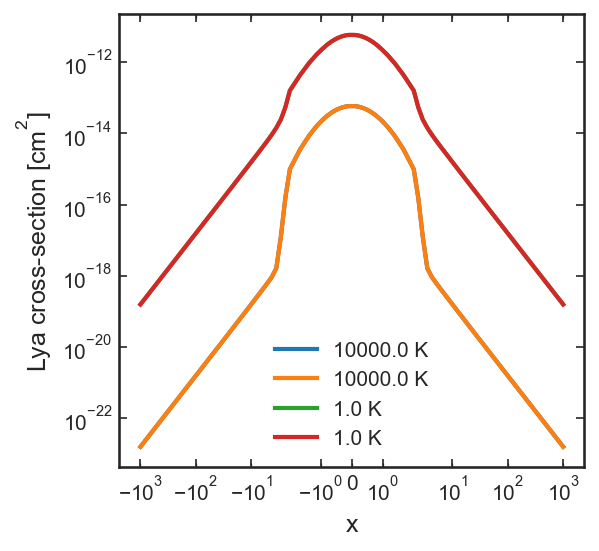

In [44]:
xtab_neg = -np.logspace(-1,3)
xtab_pos = -xtab_neg
xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))

T_tab = [1e4*u.K, 1*u.K]

for T in T_tab:
    crosssec = bubbles.lya_cross_section(T)
    wave     = crosssec.Lya_x_to_wave(xtab)

    plt.plot(xtab, crosssec.Lya_crosssec(wave=wave), label=T)
    plt.plot(xtab, crosssec.Lya_crosssec_x(xtab), label=T)
#     plt.plot(xtab, crosssec.Voigt(xtab), label=T, alpha=0.8)
    
    print(np.sqrt(np.pi)/np.trapz(crosssec.Voigt(xtab), xtab))

plt.legend()
plt.xscale('symlog')
plt.yscale('log')

plt.xlabel('x')
plt.ylabel('Lya cross-section [cm$^2$]')

Text(0, 0.5, 'Lya cross-section [cm$^2$]')

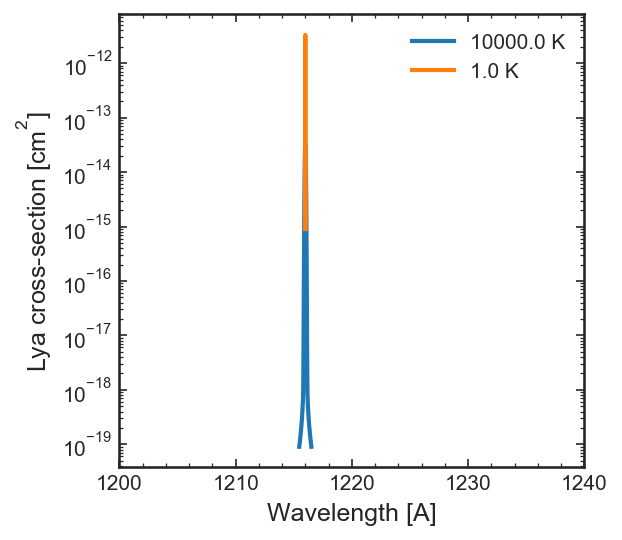

In [9]:
for T in T_tab:
    crosssec = bubbles.lya_cross_section(T)
    wave     = crosssec.Lya_x_to_wave(xtab)
    
    plt.semilogy(wave, crosssec.Lya_crosssec(wave=wave), label=T)

plt.legend()

plt.xlim(1200, 1240)
plt.xlabel('Wavelength [A]')
plt.ylabel('Lya cross-section [cm$^2$]')

## Gunn Peterson Check

<Quantity 4.64813974e-18 cm2>

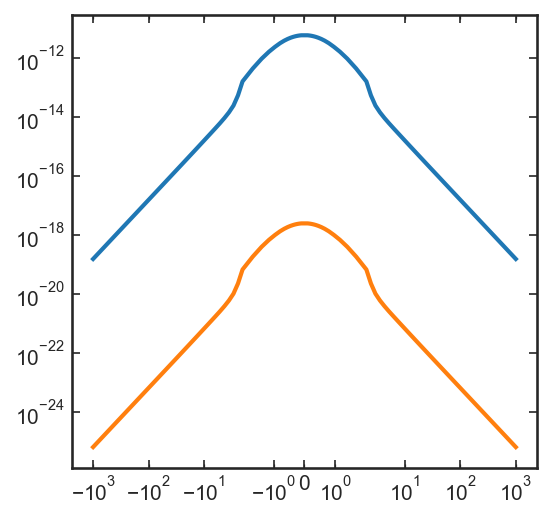

In [45]:
xtab_neg = -np.logspace(-1,3)
xtab_pos = -xtab_neg
xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))

integrand = crosssec.Lya_crosssec_x(xtab)*crosssec.dfreq_Lya / (crosssec.dfreq_Lya*xtab + bubbles.freq_Lya)

plt.plot(xtab, crosssec.Lya_crosssec_x(xtab), label='Cross-section')
plt.plot(xtab, integrand, label='integrand')
plt.xscale('symlog')
plt.yscale('log')

np.trapz(integrand, xtab)

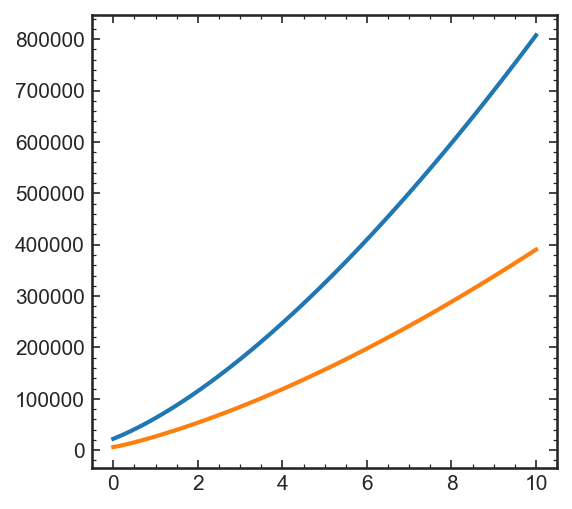

In [51]:
def tau_GP_integral(z):
    
    # Use 1/2 integral as from 0 to infinity
    integrand = crosssec.Lya_crosssec_x(xtab)*crosssec.dfreq_Lya / (crosssec.dfreq_Lya*xtab + bubbles.freq_Lya)
    tau_GP = const.c * bubbles.n_H(z)/Planck15.H(z) * 0.5*np.trapz(integrand, xtab)
    return tau_GP.to(u.cm/u.cm)

def tau_GP_approx(z):
    return 7e5 * ((1 + z)/10.)**1.5

ztab = np.linspace(0., 10)

plt.plot(ztab, tau_GP_approx(ztab))
plt.plot(ztab, tau_GP_integral(ztab))

# Estimate neutral fraction in a bubble

Use [Cen & Haiman (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJ...542L..75C/abstract), [Haiman (2004)](https://ui.adsabs.harvard.edu/abs/2002ApJ...576L...1H/abstract), [Mesinger, Haiman & Cen (2004)](https://ui.adsabs.harvard.edu/abs/2004ApJ...613...23M/abstract)

## Bubble size

In [6]:
# Matthee+18
bubbles.R_bubble_CenHaiman2000(z_s=6.6, Ndot_ion=1e54/u.s, t_source=1.e7*u.yr) # proper size of ionized bubble

<Quantity 0.31447496 Mpc>

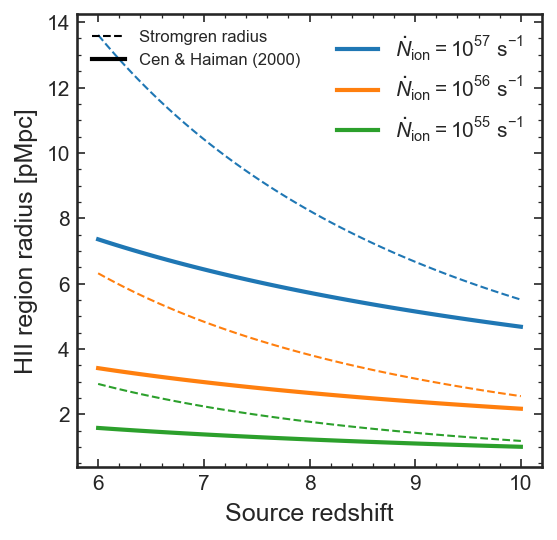

In [7]:
ztab = np.linspace(6., 10)

Ndot_ion_tab = [1.e57, 1.e56, 1.e55]

for Ndot_ion in Ndot_ion_tab:
    
    ln = plt.plot(ztab, bubbles.R_bubble_Stromgren(ztab, Ndot_ion=Ndot_ion/u.s),
                 ls='dashed', lw=1)  
    
    plt.plot(ztab, bubbles.R_bubble_CenHaiman2000(ztab, Ndot_ion=Ndot_ion/u.s, 
                                          t_source=1.e8*u.yr),
             c=ln[0].get_color(),
             label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion))


stromgren_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='Stromgren radius')
CenHaiman_line = mlines.Line2D([], [], color='k', lw=2, label='Cen & Haiman (2000)')

leg = plt.legend(handles=[stromgren_line, CenHaiman_line], loc='upper left', fontsize=8)
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [pMpc]')

plt.savefig('../figs/R_HII_compare.pdf')

### Change age

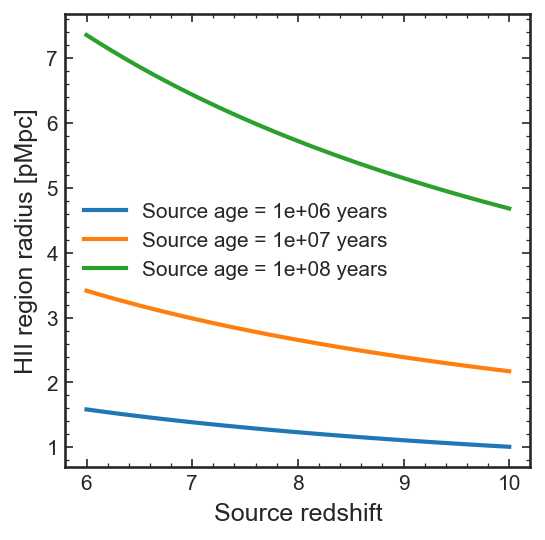

In [8]:
ztab = np.linspace(6., 10)

age_tab = np.logspace(-1, 1, 3)*1e7*u.year

for age in age_tab:
    
    plt.plot(ztab, bubbles.R_bubble_CenHaiman2000(ztab, Ndot_ion=1e57/u.s, 
                                                  t_source=age),
             label='Source age = %.0e years' % age.value)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [pMpc]')

plt.savefig('../figs/R_HII_age.pdf')

## Neutral fraction

In [9]:
Rtab = np.logspace(-2., 1.5, 200) * u.Mpc

### As a function of Nion

[6.58781152e+53 4.15662806e+54 2.62265500e+55 1.65478344e+56] 1 / s


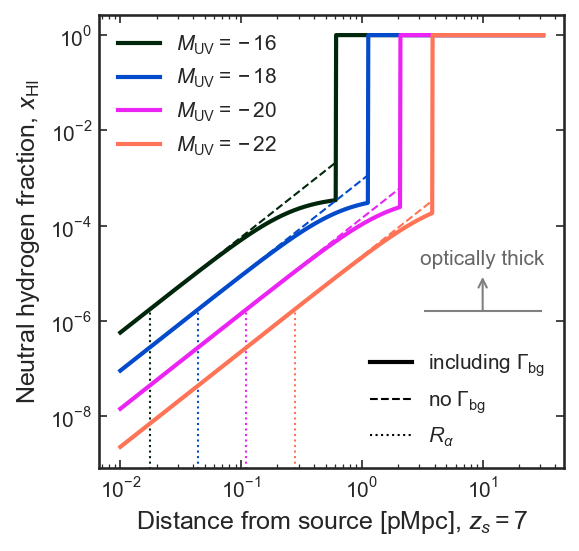

In [45]:
Muv_tab = np.array([-16, -18, -20, -22])

Ndot_ion_tab = bubbles.Muv_to_Nion(Muv=Muv_tab, z=7)
print(Ndot_ion_tab)

Rtab = np.logspace(-2., 1.5, 1000)*u.Mpc

z_s = 7.

fesc_test = 1.
C_test = 3.
alpha_s_test = -2.

for i, Ndot_ion in enumerate(Ndot_ion_tab):
       
    # Find full ionized bubble
    R3 = odeint(bubbles.dRion3_dt, y0=0., t=[0, 1e8], args=(z_s, fesc_test*Ndot_ion, C_test), tfirst=True)
    R_HII = R3.T[0][1]**(1/3.) * u.Mpc
#     R_CenHaiman = bubbles.R_bubble_CenHaiman2000(z_s, Ndot_ion=Ndot_ion, t_source=1e8*u.yr)
#     plt.axvline(R_CenHaiman.value, lw=1, c=col[3+i*4], ls='dashed')            
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, Ndot_ion=Ndot_ion, fesc=1, J_bg=0.)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, lw=1, c=col[1+i*3], ls='dashed')

    # With background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, Ndot_ion=Ndot_ion, fesc=1, J_bg=1.)    
    xHI_radial[Rtab > R_HII] = 1.
    
    plt.loglog(Rtab, xHI_radial, lw=2, c=ln[0].get_color(),
               label='$M_\mathrm{UV} = %.0f$' % Muv_tab[i])

    R_alpha = bubbles.R_optically_thin(z=z_s, Ndot_ion=Ndot_ion, 
                                   reccase='B', alpha_s=alpha_s_test, 
                                   fesc=fesc_test, C=C_test, T=1e4*u.K, J_bg=0)

    plt.plot([R_alpha.value]*2, [0., xHI_radial[np.argmin(np.abs(Rtab - R_alpha))]], 
            lw=1, ls='dotted', c=ln[0].get_color())


        
background_line   = mlines.Line2D([], [], color='k', lw=2, label='including $\Gamma_\mathrm{bg}$')
nobackground_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='no $\Gamma_\mathrm{bg}$')
ralpha_line = mlines.Line2D([], [], color='k', lw=1, ls='dotted', label=r'$R_\alpha$')

plt.axhline(1.6e-6, xmin=0.7, xmax=0.95, lw=1, c='0.5', zorder=0)
plt.annotate('optically thick', xy=(10, 1.4e-6), xytext=(10,2e-5), xycoords='data',
            arrowprops={'arrowstyle': '<-', 'lw':1, 'color':'0.5'}, color='0.4', ha='center', va='center')


leg = plt.legend(handles=[background_line, nobackground_line, ralpha_line], loc='lower right')
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Distance from source [pMpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $x_\mathrm{HI}$')

plt.savefig('../figs/xHI_profiles/x_HI_withbg_zs=%.0f.pdf' % z_s, bbox_inches='tight')

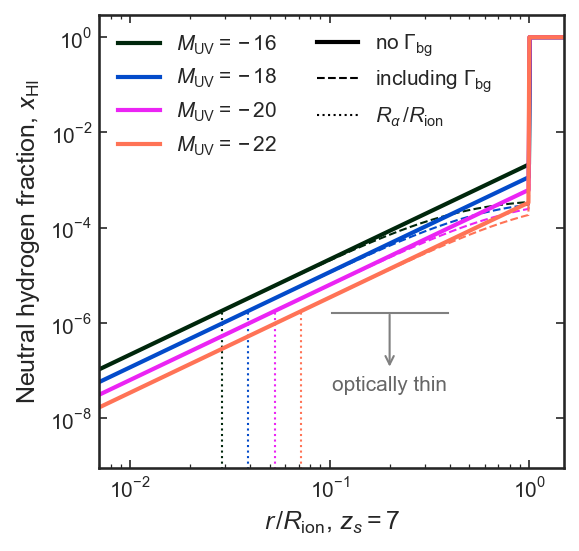

In [86]:
mycol = ['#301317','#3E3046','#1B5866','#2A7C59','#8B9237','#F69456']

Muv_tab = np.array([-16, -18, -20, -22])

Ndot_ion_tab = bubbles.Muv_to_Nion(Muv=Muv_tab, z=7)
Rtab = np.logspace(-3., 1.5, 1000)*u.Mpc

z_s = 7.

fesc_test = 1.
C_test = 3.
for i, Ndot_ion in enumerate(Ndot_ion_tab):
       
    # Find full ionized bubble
    R3 = odeint(bubbles.dRion3_dt, y0=0., t=[0, 1e8], args=(z_s, fesc_test*Ndot_ion, C_test), tfirst=True)
    R_HII = R3.T[0][1]**(1/3.) * u.Mpc
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, Ndot_ion=Ndot_ion, fesc=1, J_bg=0.)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab/R_HII, xHI_radial, lw=2, c=col[1+i*3], label='$M_\mathrm{UV} = %.0f$' % Muv_tab[i])

    # With background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, Ndot_ion=Ndot_ion, fesc=1, J_bg=1.)    
    xHI_radial[Rtab > R_HII] = 1.
    
    plt.loglog(Rtab/R_HII, xHI_radial, lw=1, c=ln[0].get_color(), ls='dashed',
               )

    R_alpha = bubbles.R_optically_thin(z=z_s, Ndot_ion=Ndot_ion, 
                                   reccase='B', alpha_s=-2, 
                                   fesc=fesc_test, C=C_test, T=1e4*u.K, J_bg=0)
    
    plt.plot([R_alpha/R_HII]*2, [0., xHI_radial[np.argmin(np.abs(Rtab - R_alpha))]], 
            lw=1, ls='dotted', c=ln[0].get_color())
    
    
# plt.axhline(1.6e-6, xmin=0.0, xmax=0.625, lw=1, c='0.5', zorder=0)
plt.axhline(1.6e-6, xmin=0.5, xmax=0.75, lw=1, c='0.5', zorder=0)
plt.annotate('optically thin', xy=(0.2, 1.8e-6), xytext=(0.2,5e-8), xycoords='data',
            arrowprops={'arrowstyle': '<-', 'lw':1, 'color':'0.5'}, color='0.4', ha='center', va='center')


background_line   = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='including $\Gamma_\mathrm{bg}$')
nobackground_line = mlines.Line2D([], [], color='k', lw=2, label='no $\Gamma_\mathrm{bg}$')
ralpha_line = mlines.Line2D([], [], color='k', lw=1, ls='dotted', label=r'$R_\alpha\,/R_\mathrm{ion}$')

leg = plt.legend(handles=[nobackground_line, background_line, ralpha_line], loc=(0.45,0.73))
plt.gca().add_artist(leg)

plt.legend()

plt.xlim(7e-3, 1.5e0)
plt.ylim(9e-10, 3e0)

plt.xlabel('$r\,/R_\mathrm{ion}, \, z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $x_\mathrm{HI}$')

plt.savefig('../figs/xHI_profiles/x_HI_withbg_zs=%.0f_selfsimilar.pdf' % z_s, bbox_inches='tight')

### As a function of UV background fluctuation

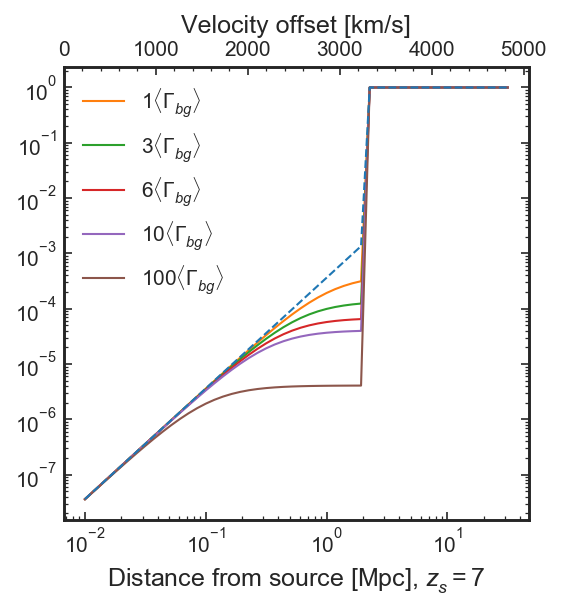

In [38]:
z_s = 7.
fesc = 0.01

Ndot_ion = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc/2., qso=True)

R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)

# No background
xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=None)    
xHI_radial[Rtab > R_HII] = 1.


ax_r  = plt.subplot()
ax_DV = ax_r.twiny()

ax_r.loglog(Rtab, xHI_radial, zorder=fesc, lw=1, ls='dashed')

def Rcom_to_DV(Rcom, z):
    return (Rcom*Planck15.H(z)/(1.+z)).to(u.km/u.s)

# Plot
ax_DV.plot(Rcom_to_DV(Rtab, z=z_s), xHI_radial, lw=0)

J_bg_tab = [1, 3., 6., 10., 100]
for J_bg in J_bg_tab:

    # With background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=J_bg)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ax_r.loglog(Rtab, xHI_radial, zorder=0, lw=1,
               label=r'$%.0f \langle \Gamma_{bg} \rangle$' % J_bg)
    

# Set xlims
# ax_DV.set_xlim(DV_min, DV_max)
ax_DV.set_xlim(Rcom_to_DV(np.array(ax_r.get_xlim())*u.Mpc, z=z_s).value)

ax_DV.set_xlabel('Velocity offset [km/s]')

ax_r.legend()

ax_r.set_xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_change_bg_zs=%.0f.pdf' % z_s)

### As a function of spectral index

1.9935457956050737e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s


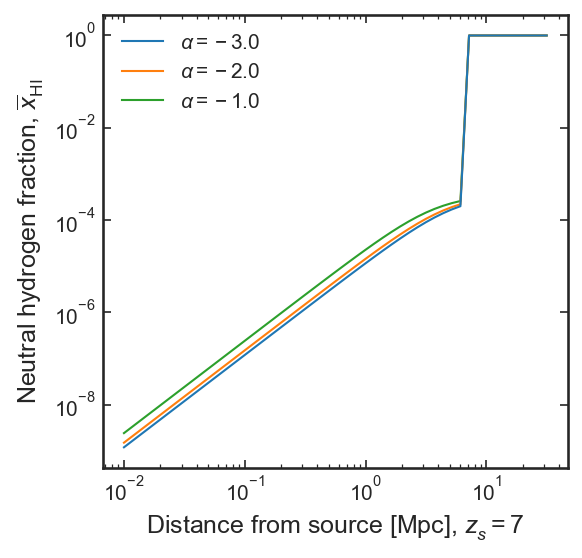

In [17]:
fesc_scale = 0.1
Ndot_ion_18 = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc_scale, qso=True, alpha=-1.8)
z_s = 7.

alpha_tab = [-3, -2, -1.]
for alpha in alpha_tab:
    
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc_scale, qso=True, alpha=alpha)

    fesc = fesc_scale * Ndot_ion_18/Ndot_ion
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc, qso=True, alpha=alpha)
    print(Ndot_ion, Ndot_ion_18)

    R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc, J_bg=True, alpha=alpha)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=1,
                   label=r'$\alpha = %.1f$' % alpha)

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_spectralindex.pdf')

### As a function of temperatures

Text(0, 0.5, 'Case B recombination coefficient [cm$^3$ s$^{-1}$]')

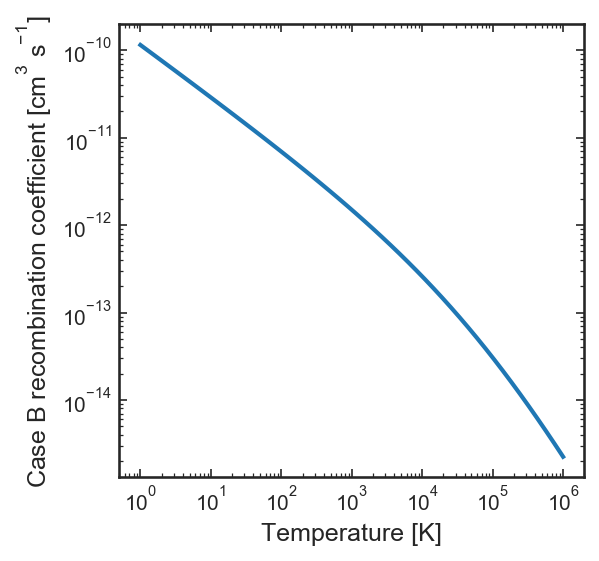

In [129]:
T = np.logspace(0, 6)

plt.loglog(T, bubbles.alpha_rec_B(T))

plt.xlabel('Temperature [K]')
plt.ylabel('Case B recombination coefficient [cm$^3$ s$^{-1}$]')

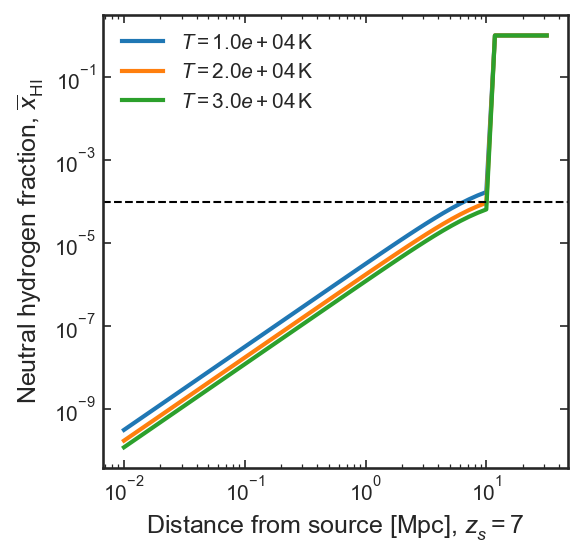

In [134]:
Ndot_ion_18 = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=0.5, qso=True, alpha=-1.8)

z_s = 7.
R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion_18)

T_tab = [1e3, 1e4, 1e5, 1e6]
T_tab = [1e4, 2e4, 3e4]
for T in T_tab:
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=0.5, J_bg=True, T=T)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, lw=2,
                   label=r'$T = %.1e\,$K' % T)

plt.axhline(1e-4, ls='dashed', lw=1, c='k')

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_temperature.pdf')

### As a function of redshift

Text(0, 0.5, 'Residual neutral fraction at 0.1 Mpc')

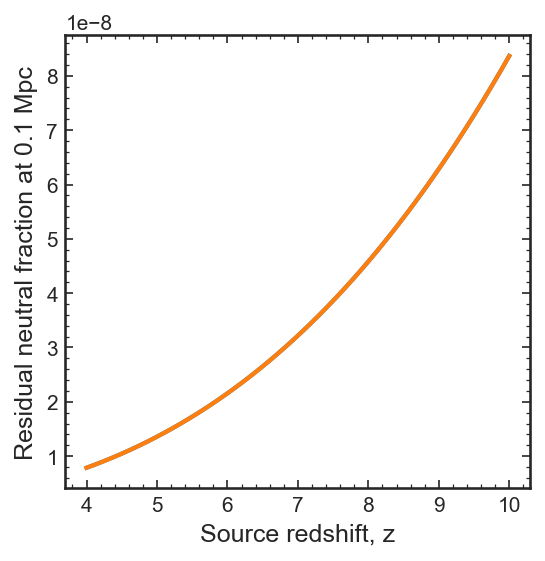

In [20]:
ztab = np.linspace(4., 10.)

fesc     = 1
Ndot_ion = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc/2., qso=True)

R_HII = bubbles.R_bubble_Stromgren(ztab, Ndot_ion=Ndot_ion)
    
# No background
xHI_radial = bubbles.xHI_R(r=0.1*u.Mpc, z_s=ztab, fesc=fesc/2., J_bg=False) 
plt.plot(ztab, xHI_radial)

xHI_radial = bubbles.xHI_R(r=0.1*u.Mpc, z_s=ztab, fesc=fesc/2., J_bg=True) 
plt.plot(ztab, xHI_radial)

plt.xlabel('Source redshift, z')
plt.ylabel('Residual neutral fraction at 0.1 Mpc')

## Ionization front ODE

R is in proper Mpc

$$ \frac{dR^3}{dt} = 3 H(z) R^3 + \frac{3 \dot{N}_{ion}}{4\pi n_H} - C n_H \alpha_B R^3$$

$$ \frac{dR^3}{dz} + \frac{C n_H \alpha_B - 3 H(z)}{(1+z)H(z)} R^3 = \frac{3 \dot{N}_{ion}}{4\pi n_H (1+z)H(z)}$$

$\alpha_B = 2.59\times^{-13}$ cm^3/s (Draine p. 138, table 14.1)


### Contribution of each part of Eqn

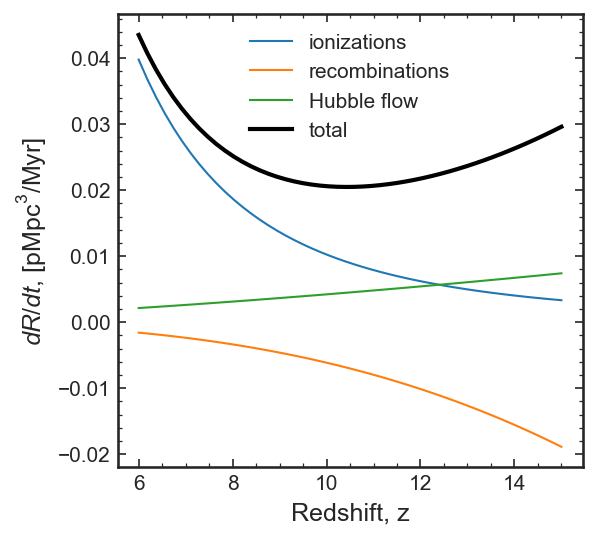

In [54]:
ztab = np.linspace(6, 15.)

horizon = (const.c/Planck15.H(z=ztab)).to(u.Mpc)
# print(horizon)

R = 3.*u.Mpc
Ndot_ion = 1.e55/u.s

dRdt_ion = bubbles.ionization_front_ionizations(ztab, Ndot_ion=Ndot_ion)
dRdt_rec = bubbles.ionization_front_recombinations(ztab, R=R)
dRdt_Hub = bubbles.ionization_front_Hubble(ztab, R=R)

plt.plot(ztab, dRdt_ion.to(u.Mpc**3/u.Myr), lw=1, label='ionizations')
plt.plot(ztab, dRdt_rec.to(u.Mpc**3/u.Myr), lw=1, label='recombinations')
plt.plot(ztab, dRdt_Hub.to(u.Mpc**3/u.Myr), lw=1, label='Hubble flow')

plt.plot(ztab, (dRdt_ion - dRdt_rec + dRdt_Hub).to(u.Mpc**3/u.Myr), c='k', label='total')

plt.xlabel('Redshift, z')
plt.ylabel('$dR/dt$, [pMpc$^3$/Myr]')

plt.legend()

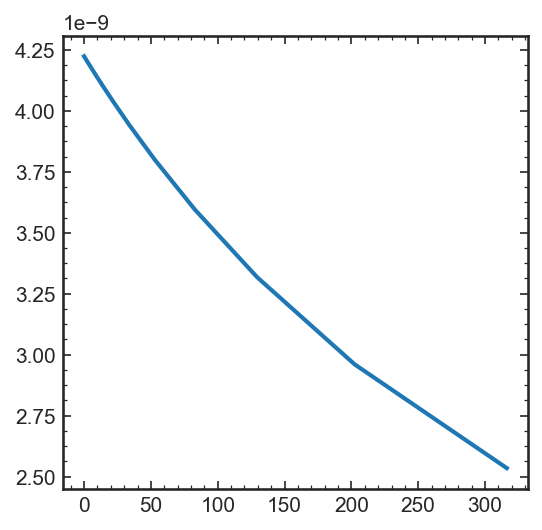

In [367]:
t_tab = np.logspace(-1, 8.5)

z_s0 = 10.

# Age of universe when source turned on
t_source_on = Planck15.age(z=z_s0)

# At age of source, t, what is redshift?
t_now = t_tab*u.yr + t_source_on
z_tab_sourceage = np.array([z_at_value(Planck15.age, time) for time in t_now])

plt.plot(t_tab/1e6, bubbles.ionization_front_Hubble(z_tab_sourceage, R=1*u.Mpc))

### Solve ODE

#### Compare solvers

solve_ivp a little faster

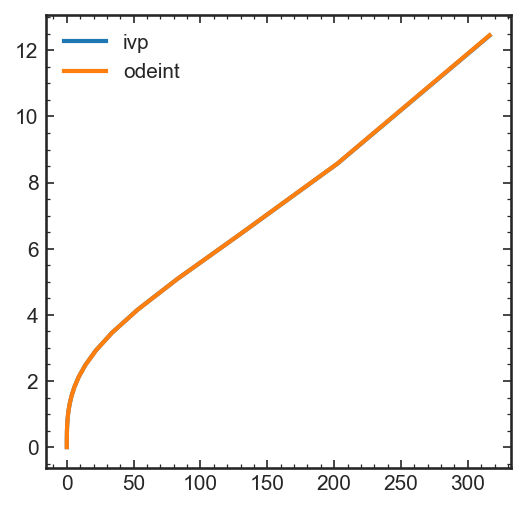

In [6]:
z_s0     = 10
# Redshift source turned on

Ndot_ion = 1e57/u.s
t_tab    = np.logspace(-1, 8.5)
# t_tab = np.linspace(0, 3e8)

args = z_s0, Ndot_ion

sol = solve_ivp(fun=lambda t, y: bubbles.dRion3_dt(t, y, *args), t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_ivp = sol.y.T**(1/3.)

R3 = odeint(bubbles.dRion3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)
R_odeint = R3.T[0]**(1/3.)

plt.plot(t_tab/1e6, R_ivp, label='ivp')
plt.plot(t_tab/1e6, R_odeint, label='odeint')
plt.legend()

In [7]:
%timeit solve_ivp(fun=lambda t, y: bubbles.dRion3_dt(t, y, *args), t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, method='RK23', vectorized=True, )
%timeit odeint(bubbles.dRion3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)

1.12 s ± 379 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.65 s ± 283 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Compare to Cen & Haiman bubble growth

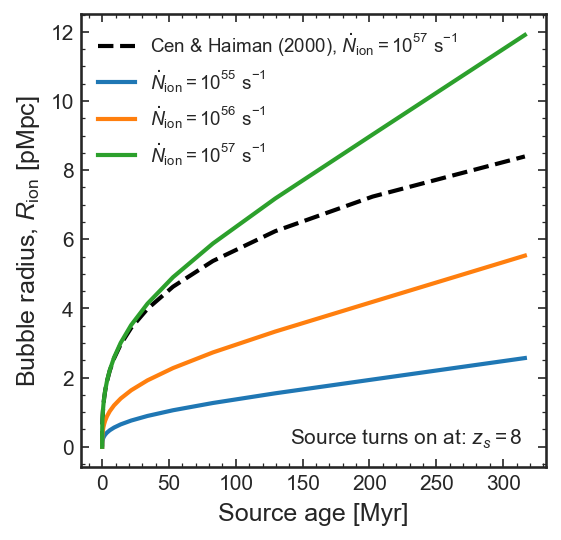

In [5]:
t_tab = np.linspace(0, 3e8)
t_tab = np.logspace(-1, 8.5)

z_s0 = 8 # Redshift source turned on

Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

plt.plot(t_tab/1e6, bubbles.R_bubble_CenHaiman2000(z_s0, Ndot_ion=1.e57/u.s, t_source=t_tab*u.yr), 
         ls='dashed', c='k', label='Cen & Haiman (2000), $\dot{N}_\mathrm{ion} = 10^{57}$ s$^{-1}$')

for Ndot_ion_i in Ndot_ion_tab:
            
    R3 = odeint(bubbles.dRion3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion_i), tfirst=True)
    R = R3.T[0]**(1/3.)
    
    plt.plot(t_tab/1e6, R, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion_i.value))
    
#     plt.semilogx(t_tab, R/R_S, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
#     R3 = odeint(bubbles.dRion3_dt, y0=0., t=[0, 1e6], args=(z_s0, Ndot_ion_i), tfirst=True)
#     R_1e6 = R3.T[0]**(1/3.)
#     print(R_1e6)
#     plt.scatter(1, R_1e6[1])
    
        
plt.annotate('Source turns on at: $z_s = %.0f$' % z_s0, xy=(0.95, 0.05), xycoords='axes fraction', ha='right')
    
plt.xlabel('Source age [Myr]')
plt.ylabel(r'Bubble radius, $R_\mathrm{ion}$ [pMpc]')
    
plt.legend(fontsize=9)

# plt.savefig('../figs/R_HII_age_compareCH00.pdf', bbox_inches='tight')

### Compare to R_alpha a function of source redshift

In [4]:
Muv_tab = np.array([-16, -18., -20, -22, -24.])
Muv_tab = np.array([-16, -18, -20, -22.])

Ndot_ion_tab = bubbles.Muv_to_Nion(Muv=Muv_tab, z=7)
Ndot_ion_tab

<Quantity [6.58781152e+53, 4.15662806e+54, 2.62265500e+55, 1.65478344e+56] 1 / s>

In [5]:
# Check ionizing equilibrium time
def J_s(Ndot_ion, fesc=1., alpha=-2):
    sigma_ion0 = 6.3e-18 * u.cm**2
    J_source = fesc * Ndot_ion * (alpha/(alpha - 3)) * sigma_ion0
    return J_source

def t_eq(J_source, R_bubble):
    inv_teq = J_source / (4.*np.pi) / (R_bubble**2.)
    return (1./inv_teq).to(u.Myr)

for i,Muv in enumerate(Muv_tab):
    Js = J_s(Ndot_ion_tab[i])
    print('Muv = {0:.0f}, t_eq = {1:2.1e}'.format(Muv, t_eq(J_source=Js, R_bubble=0.5*u.Mpc)))
    

Muv = -16, t_eq = 5.7e-01 Myr
Muv = -18, t_eq = 9.0e-02 Myr
Muv = -20, t_eq = 1.4e-02 Myr
Muv = -22, t_eq = 2.3e-03 Myr


In [6]:
t_age_tab = np.logspace(6., 8, 3)*u.yr
print(t_age_tab)
z_now_tab = np.linspace(5, 10, 10) # Redshift source observed

# What redshift did source form?
t_now = Planck15.age(z=z_now_tab)

fesc_test = 1.
C_test    = 3.
alpha_s_test = -2.

R_dict = {}
for Ndot_ion in Ndot_ion_tab:

    R_dict[Ndot_ion] = {}
    R_dict[Ndot_ion]['R_ion'] = {}
    R_dict[Ndot_ion]['R_alpha'] = {}
    print('\nNion = {:.1e}'.format(Ndot_ion))
    
    for t_age in t_age_tab:
        
        t_source_on = t_now - t_age
        z_source_on = np.array([z_at_value(Planck15.age, time) for time in t_source_on])

        # Find full ionized bubble
        R3 = np.array([odeint(bubbles.dRion3_dt, y0=0., t=[0, t_age.value], \
                              args=(z_0, fesc_test*Ndot_ion, C_test), tfirst=True) for z_0 in z_source_on])
        R  = R3.T[0][1]**(1/3.) * u.Mpc    
        R_dict[Ndot_ion]['R_ion'][t_age] = R

        # Optically thin region
        R_alpha = bubbles.R_optically_thin(z=z_now_tab, Ndot_ion=Ndot_ion, 
                                           reccase='B', alpha_s=alpha_s_test, fesc=fesc_test, 
                                           C=C_test, T=1e4*u.K) 
        
        print('Age:{0:.0f}, t_eq:{1:.1e}'.format(t_age.to(u.Myr), t_eq(J_source=J_s(Ndot_ion), R_bubble=R_alpha.max())))
        
        R_dict[Ndot_ion]['R_alpha'][t_age] = R_alpha
        
        boundary = np.where(R_alpha.value - R.value > 0)
        R_dict[Ndot_ion]['R_alpha'][t_age][boundary] = R_dict[Ndot_ion]['R_ion'][t_age][boundary]
            

[1.e+06 1.e+07 1.e+08] yr

Nion = 6.6e+53 1 / s
Age:1 Myr, t_eq:2.6e-03 Myr
Age:10 Myr, t_eq:2.6e-03 Myr
Age:100 Myr, t_eq:2.6e-03 Myr

Nion = 4.2e+54 1 / s
Age:1 Myr, t_eq:2.6e-03 Myr
Age:10 Myr, t_eq:2.6e-03 Myr
Age:100 Myr, t_eq:2.6e-03 Myr

Nion = 2.6e+55 1 / s
Age:1 Myr, t_eq:2.6e-03 Myr
Age:10 Myr, t_eq:2.6e-03 Myr
Age:100 Myr, t_eq:2.6e-03 Myr

Nion = 1.7e+56 1 / s
Age:1 Myr, t_eq:2.6e-03 Myr
Age:10 Myr, t_eq:2.6e-03 Myr
Age:100 Myr, t_eq:2.6e-03 Myr


In [7]:
# Blue peak observations 
observations = {}
observations['COLA1'] = {'z':6.6, 'vlim':250, 'M1500':-21.6, 'c':'0.3', 'ms':'s'}
observations['MACS1149-JD1'] = {'z':9.11, 'vlim':450, 'M1500':-18.5, 'c':'0.5', 'ms':'o'}

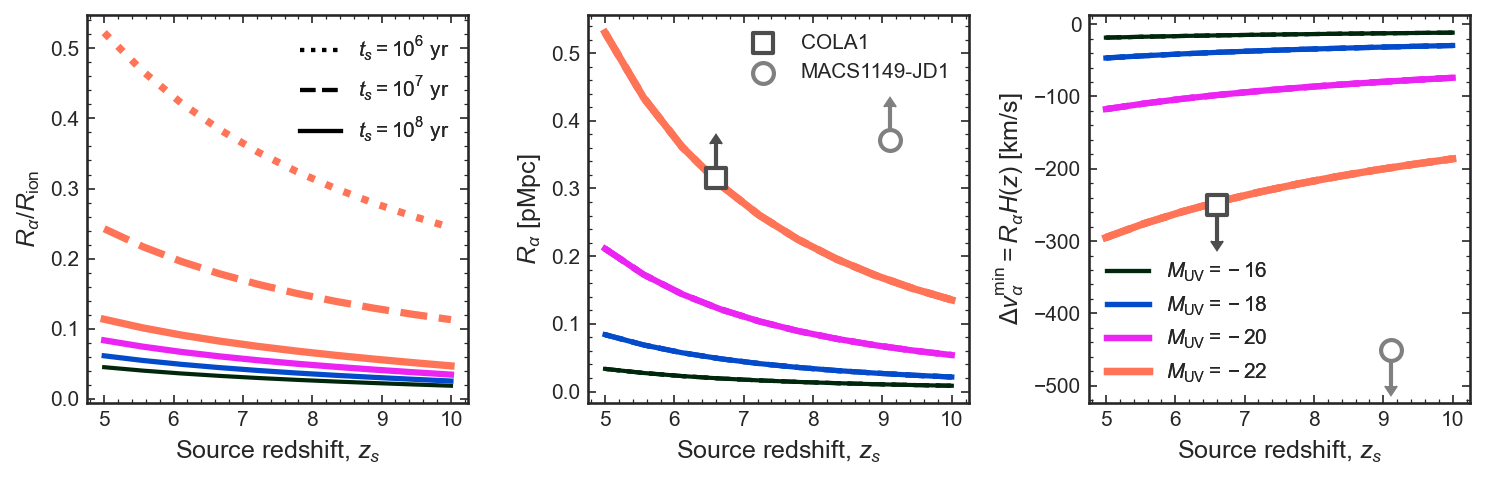

In [26]:
fig, axs = plt.subplots(1,3, figsize=(10, 3.3), dpi=150)
axs = axs.ravel()

# ========================
# Ratio
ls = ['dotted','dashed','solid']
for i, Ndot_ion in enumerate(Ndot_ion_tab):
        
    if i==3:
        for tt, t_age in enumerate(t_age_tab):
               
            ln = axs[0].plot(z_now_tab, R_dict[Ndot_ion]['R_alpha'][t_age]/R_dict[Ndot_ion]['R_ion'][t_age]/u.Mpc, 
                              lw=2+i/2,
                              c=col[1+i*3], 
                              ls=ls[tt])
    else:
        ln = axs[0].plot(z_now_tab, R_dict[Ndot_ion]['R_alpha'][t_age_tab[-1]]/R_dict[Ndot_ion]['R_ion'][t_age_tab[-1]]/u.Mpc, 
                        lw=2+i/2,
                        c=col[1+i*3], 
                        ls='solid')
    
handles = []
for tt, t_age in enumerate(t_age_tab):
    handles.append(mlines.Line2D([], [], c='k', ls=ls[tt],
                                 label='$t_s = 10^%.0f$ yr' % np.log10(t_age.value)))
leg = axs[0].legend(handles=handles, ncol=1, loc='upper right')
axs[0].add_artist(leg)
    
axs[0].set_xlabel('Source redshift, $z_s$')
axs[0].set_ylabel(r'$R_\alpha/R_\mathrm{ion}$')
# axs[0].set_yscale('log')

# ========================
# R_alpha proper size
for i, Ndot_ion in enumerate(Ndot_ion_tab):
    
    for t_age in t_age_tab:
        
        ln = axs[1].plot(z_now_tab, R_dict[Ndot_ion]['R_alpha'][t_age],#*(1+z_now_tab), 
                          lw=2+i/2,
                          c=col[1+i*3], 
                          ls=ls[np.argmin(np.abs(np.array(t_age_tab.value) - t_age.value))],
                          )

for ob in observations:
    
    R_alpha_min = ((observations[ob]['vlim']*u.km/u.s)/Planck15.H(observations[ob]['z'])).to(u.Mpc).value
    axs[1].scatter(observations[ob]['z'], R_alpha_min,
                    lw=2, edgecolors=observations[ob]['c'], facecolor='w', 
                    s=100, marker=observations[ob]['ms'], 
                    zorder=1000, label=ob)
    axs[1].errorbar(observations[ob]['z'], R_alpha_min, 
                    yerr=0.05,
                    lw=2, color=observations[ob]['c'], lolims=True, zorder=100)
    
handles = []
for i, Ndot_ion in enumerate(Ndot_ion_tab):
    handles.append(mlines.Line2D([], [], color=col[1+i*3], lw=2+i/2, 
                                 label='$M_\mathrm{UV} = %.0f$' % Muv_tab[i]))
leg = axs[2].legend(handles=handles, ncol=1)
axs[2].add_artist(leg)

axs[1].set_xlabel('Source redshift, $z_s$')
axs[1].set_ylabel(r'$R_\alpha$ [pMpc]')
# axs[1].set_yscale('log')

# ========================
# R_alpha velocity offset

for ob in observations:
    axs[2].scatter(observations[ob]['z'], -observations[ob]['vlim'],
                    lw=2, edgecolors=observations[ob]['c'], facecolor='w', 
                    s=100, marker=observations[ob]['ms'], 
                    zorder=1000, label=ob)
    axs[2].errorbar(observations[ob]['z'], -observations[ob]['vlim'], 
                    yerr=50,
                    lw=2, color=observations[ob]['c'], uplims=True, zorder=100)

for i, Ndot_ion in enumerate(Ndot_ion_tab):
    
    for t_age in t_age_tab:

        ln = axs[2].plot(z_now_tab, 
                          -bubbles.blue_velocity_lim(R_dict[Ndot_ion]['R_alpha'][t_age], z=z_now_tab),
                          lw=2+i/2,
                          c=col[1+i*3], 
                          ls=ls[np.argmin(np.abs(np.array(t_age_tab.value) - t_age.value))])
axs[1].legend()            
axs[2].set_xlabel('Source redshift, $z_s$')
axs[2].set_ylabel(r'$\Delta v_\alpha^\mathrm{min} = R_\alpha H(z)$ [km/s]')
# axs[2].set_yscale('log')

fig.tight_layout()
# fig.subplots_adjust(wspace=0.4)

fig.savefig('../figs/RHII_Ralpha_DV_redshift_all.pdf', bbox_inches='tight')

### Fluctuating Nion

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in power


Text(0, 0.5, '$\\dot{N}_\\mathrm{ion}$ [s$^{-1}$]')

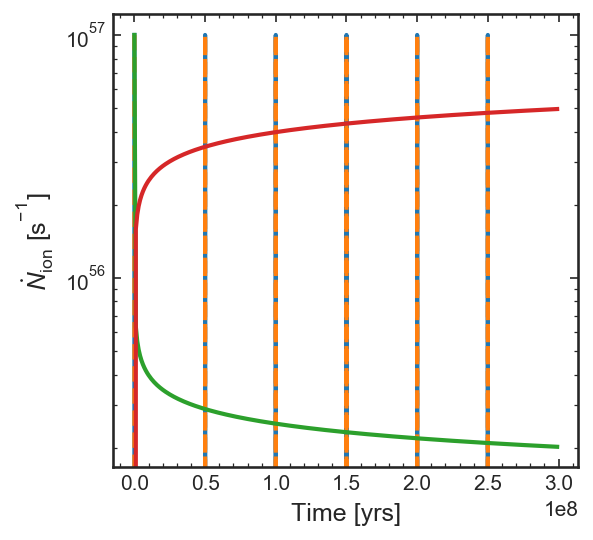

In [222]:
def Ndot_ion_burst(t, burst_freq=5e7*u.yr, burst_height=1.e57, min_diff=1e6):
    """
    Make Ndot_ion equally spaced bursts every burst_freq years
    """
    try: # if array
        bursts = np.arange(0, max(t)+1, burst_freq.value)
        Ndot_ion = np.zeros(len(t))
#         burst_match = [np.abs(burst - t) < min_diff for burst in bursts]
        Ndot_ion[np.in1d(t, bursts)] = burst_height
    except: # float
        bursts = np.arange(0, t+1, burst_freq.value)
#         print(bursts - t)
        if np.any(np.abs(bursts - t) < min_diff):
            Ndot_ion = burst_height
        else:
            Ndot_ion = 0.
        
    return Ndot_ion

def Ndot_ion_powerlaw(t, alpha=-2., Ndot_ion_0=1.e57):
    try:
        if t < 1:
            Ndot_ion = Ndot_ion_0
        else:
            Ndot_ion = Ndot_ion_0 * t**alpha
    except:
        Ndot_ion = Ndot_ion_0 * t**alpha
        Ndot_ion[~np.isfinite(Ndot_ion)] = Ndot_ion_0
    return Ndot_ion

t_tab = np.arange(0., 3e8, 1e6)
# print(Ndot_ion_burst(t_tab))
# t_tab = np.logspace(-1, 8.5, 100)
plt.plot(t_tab, Ndot_ion_burst(t_tab))
plt.plot(t_tab, np.array([Ndot_ion_burst(t) for t in t_tab]), ls='dashed')
plt.semilogy(t_tab, Ndot_ion_powerlaw(t_tab, alpha=-0.2))    
plt.semilogy(t_tab, Ndot_ion_powerlaw(t_tab, alpha=0.2, Ndot_ion_0=1.e55))    

plt.xlabel('Time [yrs]')
plt.ylabel('$\dot{N}_\mathrm{ion}$ [s$^{-1}$]')

In [232]:
z_s0     = 10 # Redshift source turned on
Ndot_ion = 1e57/u.s

t_tab = np.arange(0., 5e8, 1e6)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_const = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_burst(t, burst_height=1e58)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_burst = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_powerlaw(t, alpha=-0.1)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_decline = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_powerlaw(t, alpha=0.2, Ndot_ion_0=1.e55)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_increase = sol.y.T**(1/3.)

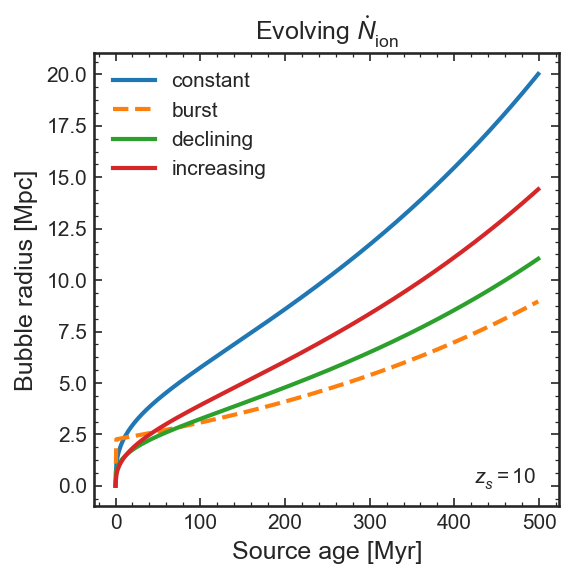

In [234]:
plt.plot(t_tab/1e6, R_const, label='constant')
plt.plot(t_tab/1e6, R_burst, ls='dashed', label='burst')
plt.plot(t_tab/1e6, R_decline, label='declining')
plt.plot(t_tab/1e6, R_increase, label='increasing')

plt.legend()
    
plt.annotate('$z_s = %.0f$' % z_s0, xy=(0.95, 0.05), xycoords='axes fraction', ha='right')

plt.title('Evolving $\dot{N}_\mathrm{ion}$')

plt.xlabel('Source age [Myr]')
plt.ylabel('Bubble radius [Mpc]')


plt.savefig('../figs/R_HII_age_evolving_Nion.pdf', bbox_inches='tight')

# Optical depth

$$ \tau(\lambda_{obs, z_s}) = \int_{z_0}^{z_s} \, dz \; c \frac{dt}{dz} n_H(z) \sigma_\alpha(\lambda_{obs}/(1+z)) $$

Neutral hydrogen density depends on HI fraction, calculate this inside the HII regions:

$$ n_H(z) = n_{H,0}(z) x_{HI}$$

In [27]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

## Simple case with Stromgren sphere

In [26]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

z_s   = 7.
z_min = 6.

Ndot_ion = 1.e57/u.s

R_ion = bubbles.R_bubble_CenHaiman2000(z_s, Ndot_ion=Ndot_ion)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

print(R_ion, z_ion)

# inside bubble
tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                        inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

3.1130177630958102 Mpc 6.991125391413053


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, 'Velocity offset [km/s]')

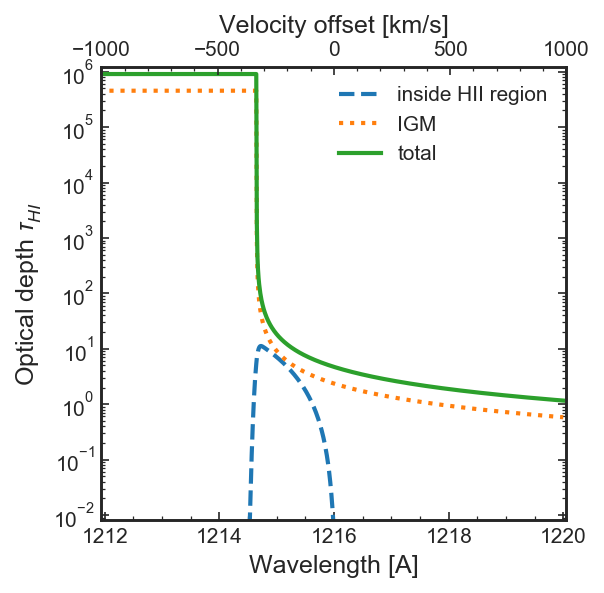

In [29]:
DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1)

ax_wave.semilogy(wave_em, tau_HII, ls='dashed', label='inside HII region')
ax_wave.semilogy(wave_em, tau_IGM, ls='dotted', label='IGM')

tau_total = tau_IGM + tau_IGM

ax_wave.semilogy(wave_em, tau_total, label='total')

ax_DV = ax_wave.twiny()
ax_DV.semilogy(DV_tab, tau_total, label='total', lw=0)

ax_wave.legend()
ax_wave.set_ylim(0.8e-2, 1.2e6)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Optical depth $\tau_{HI}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

## Cen & Haiman

Agrees with Haiman 2002, Cen & Haiman 2000

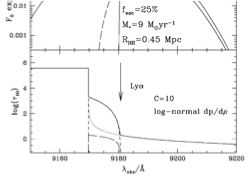

- fesc = 0.25
- SFR = 9 Msun/yr --> Nion = 1.4e54 s-1
- tage = 10^8 yr
- [yes] R_HII = 0.45 pMpc

In [36]:
# Haiman 2002
fesc     = 0.25
Ndot_ion = fesc*1.4e54/u.s 
tage     = 1e8*u.year
C   = 10
z_s = 6.55 #56

## bigger bubble
fesc     = 1
Ndot_ion = fesc*1e56/u.s 
tage     = 1e8*u.year
C   = 1

# Cen & Haiman 2000
# Ndot_ion = 2e57/u.s 
# tage     = 1e7*u.year
# C   = 3
# z_s = 7.

# R_ion is PROPER distance
R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=tage)
z_ion = bubbles.z_at_proper_distance(R_ion, z_1=z_s)
z_min = 6.
print(R_ion, z_ion)

wave_em = np.linspace(1200, 1240., 2000) * u.Angstrom

# inside bubble
tau_HII = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                                inside_HII=True, C_HII=C, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = bubbles.optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                                inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total = tau_IGM + tau_HII

3.16557580575739 Mpc 6.4875106008739305


/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


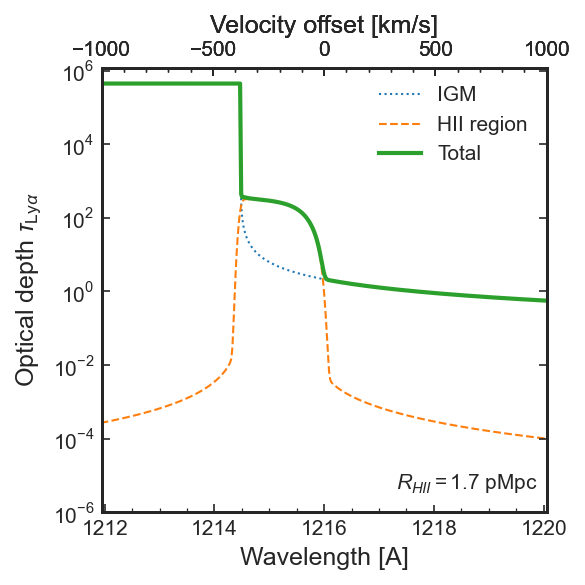

In [30]:
tau_tab = tau_HII, tau_IGM, tau_total

fig, ax = plt.subplots(1,1)

bubbles.plot_tau(tau_tab[1], wave_em, R_ion, vlim=1000, transmission=False, ax=ax, label='IGM', lw=1, ls='dotted')
plt.savefig('../figs/tau_IGM.pdf')
bubbles.plot_tau(tau_tab[0], wave_em, R_ion, vlim=1000, transmission=False, ax=ax, label='HII region', lw=1, ls='dashed')
plt.savefig('../figs/tau_plusHII.pdf')
bubbles.plot_tau(tau_tab[2], wave_em, R_ion, vlim=1000, transmission=False, ax=ax, label='Total')
plt.savefig('../figs/tau_both.pdf')
# bubbles.plot_tau(tau_tab, wave_em, R_ion, transmission=True)

### Optical depth HII on grid

2.9875121666835365 Mpc 6.9318654601732765


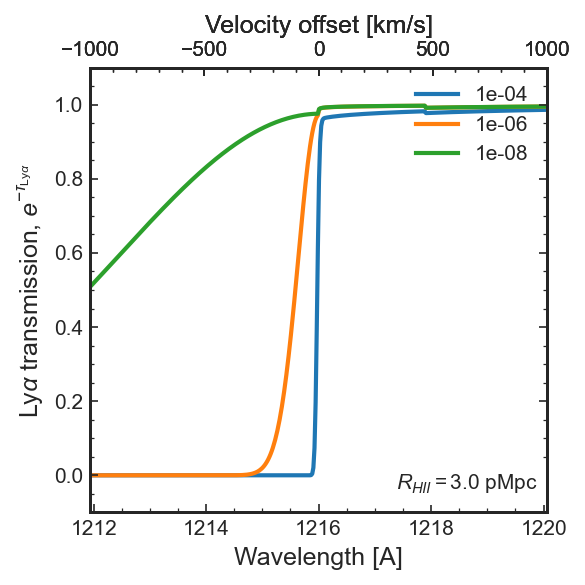

In [62]:
z_s = 7. #56
R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=tage)
z_ion = bubbles.z_at_proper_distance(R_ion, z_1=z_s)
z_min = 6.
print(R_ion, z_ion)

wave_em = np.linspace(1200, 1240., 2000) * u.Angstrom

# inside bubble
fig, ax = plt.subplots(1,1)

for xHI in [1e-4, 1e-6, 1e-8]:
    tau_HII = bubbles.optical_depth_grid(wave_em, T=1e4*u.K, z_min=6.93, z_max=7, z_s=7.,
                              inside_HII=True, C_HII=3., 
                              xHI_01=xHI, R_ion=3.*u.Mpc,
                              r_slope=2.)


    bubbles.plot_tau(tau_HII, wave_em, R_ion, vlim=1000, transmission=True, 
                     ax=ax, label=f'{xHI:.0e}')#'{:.0e}'.format(xHI), lw=1)


### Function of temperature

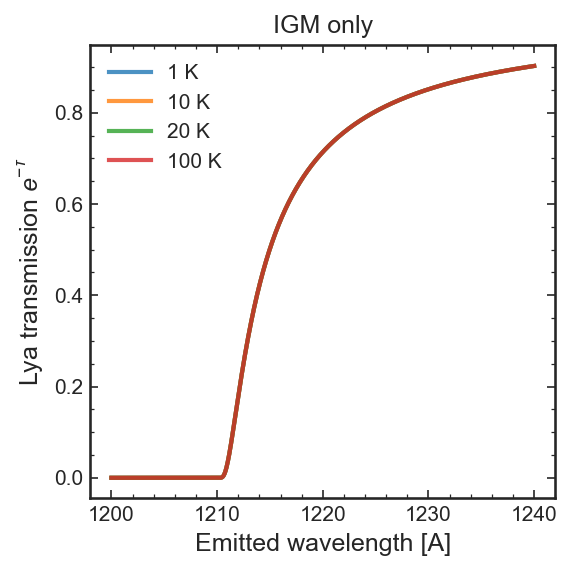

In [71]:
Ndot_ion = 2.e55/u.s 

z_s = 7.

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=1e8*u.year)
z_ion = bubbles.z_at_proper_distance(R_ion, z_1=z_s)
z_min = 6.

T_tab = [1, 10, 20, 100]

for T in T_tab:
    
    # IGM
    tau_IGM_T = bubbles.optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                                inside_HII=False, T=T*u.K, Ndot_ion=Ndot_ion)

    plt.plot(wave_em, np.exp(-tau_IGM_T), label=f'{T} K', alpha=0.8)

plt.xlabel('Emitted wavelength [A]')
# plt.ylabel(r'Lya optical depth $\tau$')
plt.ylabel(r'Lya transmission $e^{-\tau}$')

plt.title('IGM only')

plt.legend()

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


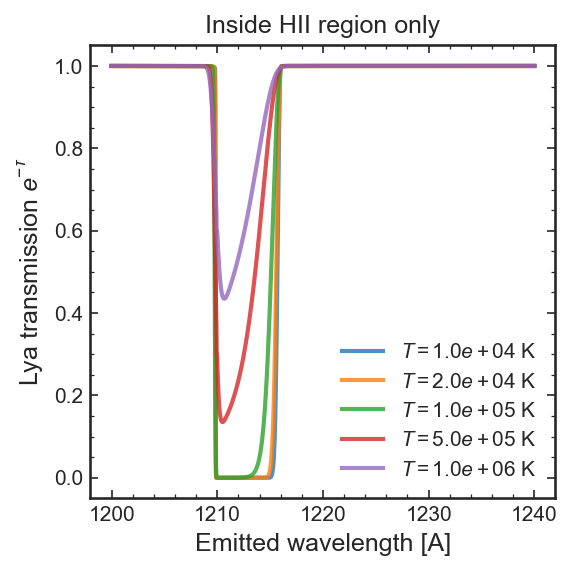

In [29]:
Ndot_ion = 2.e55/u.s 

z_s = 7.

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=1e8*u.year)
z_ion = bubbles.z_at_proper_distance(R_ion, z_1=z_s)
z_min = 6.

T_tab = [1e4, 2e4, 1e5, 5e5, 1e6]

for T in T_tab:
    tau_HII_T = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                                      inside_HII=True, T=T*u.K, Ndot_ion=Ndot_ion)
    
#     plt.semilogy(wave_em, (tau_HII_T), label='$T=%.1e$ K' % T)
    plt.plot(wave_em, np.exp(-tau_HII_T), label='$T=%.1e$ K' % T, alpha=0.8)

plt.xlabel('Emitted wavelength [A]')
# plt.ylabel(r'Lya optical depth $\tau$')
plt.ylabel(r'Lya transmission $e^{-\tau}$')

plt.title('Inside HII region only')

plt.legend()

### Make animation

#### Update Nion

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


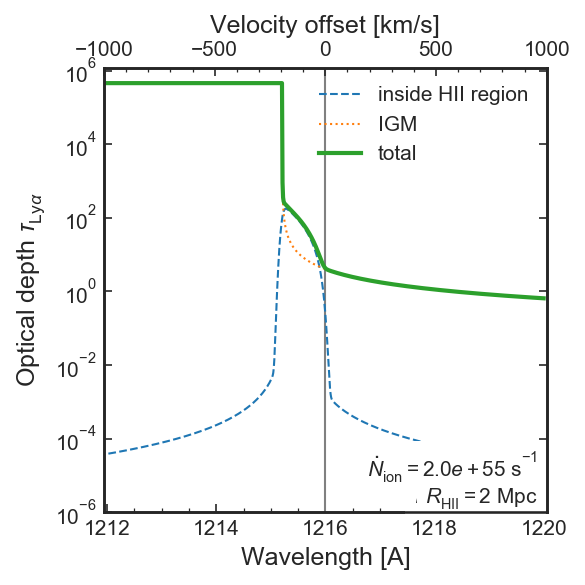

In [576]:
transmission = True
Ndot_ion_tab = np.logspace(-2, 1, 10)*2e57/u.s

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_Nion(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[i], source_age=1e8*u.year, z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'$\dot{N}_\mathrm{ion}=%.1e$ s$^{-1}$' % Ndot_ion_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[0], source_age=1e7*u.year, z_s=7., z_min=6.)
plot_tau(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau, frames=np.arange(len(Ndot_ion_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_Nion.gif'
else:
    plotname = '../figs/optdepth_animate_Nion.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

#### Update age

[1.00000000e+06 1.66810054e+06 2.78255940e+06 4.64158883e+06
 7.74263683e+06 1.29154967e+07 2.15443469e+07 3.59381366e+07
 5.99484250e+07 1.00000000e+08] yr


/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


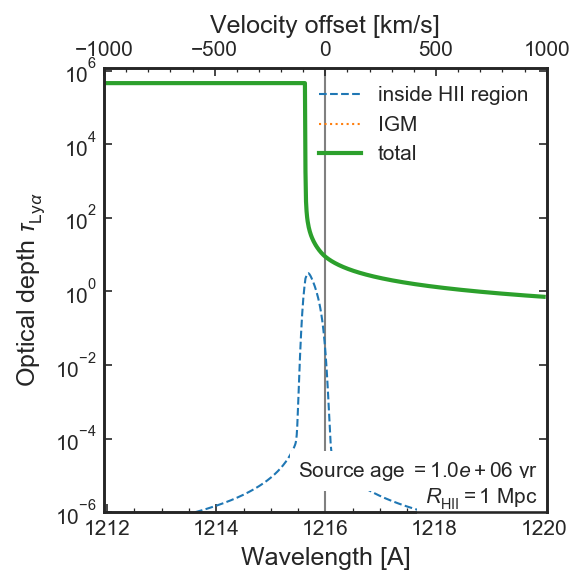

In [167]:
transmission = False
source_age_tab = np.logspace(-2, 0, 10)*1e8*u.year
print(source_age_tab)

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_age(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[i], z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'Source age $=%.1e$ yr' % source_age_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[0], z_s=7., z_min=6.)
plot_tau_all(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau_age, frames=np.arange(len(source_age_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_age.gif'
else:
    plotname = '../figs/optdepth_animate_age.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Optical depth on a grids of Muv / Nion

## Grid of Muv

In [42]:
z_s   = 7.
z_min = 6.
source_age = 1e8*u.year
wave_em = np.linspace(1200, 1240., 2000) * u.Angstrom

# Same as 3.3.3
fesc_test    = 1.
C_test       = 3.
alpha_s_test = -2.

Muv_tab = np.arange(-24, -15.5, 0.5)
Muv_tab = np.arange(-24, -15.5, 1.)
print(Muv_tab)
Ndot_ion_tab = bubbles.Muv_to_Nion(Muv=Muv_tab, z=z_s, alpha_s=alpha_s_test, beta=-2)
  
tau_tot_tab = []
R_ion_tab   = []
for Ndot_ion in Ndot_ion_tab:
    tau_tab, R_ion = bubbles.make_tau(Ndot_ion_total=fesc * Ndot_ion, source_age=source_age, 
                                      wave_em=wave_em, z_s=z_s, z_min=z_min, C=C_test, R_type='full')
    
    print('Nion = {0:.1e}, Rion = {1:.1f}'.format(Ndot_ion, R_ion))
    tau_HII, tau_IGM, tau_total = tau_tab

    R_ion_tab.append(R_ion.value)
    tau_tot_tab.append(tau_total)
    
tau_tot_tab = np.array(tau_tot_tab)
R_ion_tab   = np.array(R_ion_tab)

[-24. -23. -22. -21. -20. -19. -18. -17. -16.]
Nion = 1.0e+57 1 / s, Rion = 4.1 Mpc
Nion = 4.2e+56 1 / s, Rion = 3.1 Mpc
Nion = 1.7e+56 1 / s, Rion = 2.2 Mpc
Nion = 6.6e+55 1 / s, Rion = 1.7 Mpc
Nion = 2.6e+55 1 / s, Rion = 1.2 Mpc
Nion = 1.0e+55 1 / s, Rion = 0.9 Mpc
Nion = 4.2e+54 1 / s, Rion = 0.7 Mpc
Nion = 1.7e+54 1 / s, Rion = 0.5 Mpc
Nion = 6.6e+53 1 / s, Rion = 0.4 Mpc


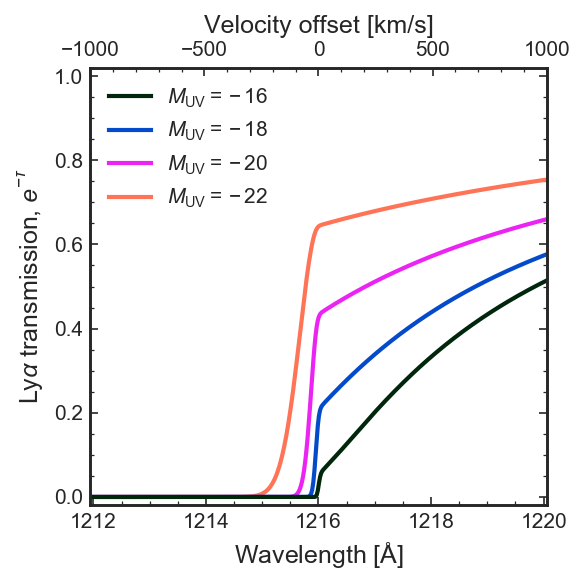

In [44]:
# Plot
DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4.,4))
ax_DV = ax_wave.twiny()

j = 3
for i, Muv in enumerate(Muv_tab):
    if Muv in [-22, -20, -18, -16]:
        ax_wave.plot(wave_em, np.exp(-tau_tot_tab[i]), c=col[1+j*3], label='$M_\mathrm{UV} = %.0f$' % Muv)
        ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[i]), lw=0)
        j -= 1

handles, labels = ax_wave.get_legend_handles_labels()
ax_wave.legend(handles[::-1], labels[::-1], loc='upper left')
# plt.yscale('linear')

ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau}$')
ax_wave.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax_DV.set_xlabel('Velocity offset [km/s]')

plt.ylim((-0.02, 1.02))
plt.tight_layout()
plt.savefig('../figs/transmission_Muv_sample.pdf', bbox_inches='tight')

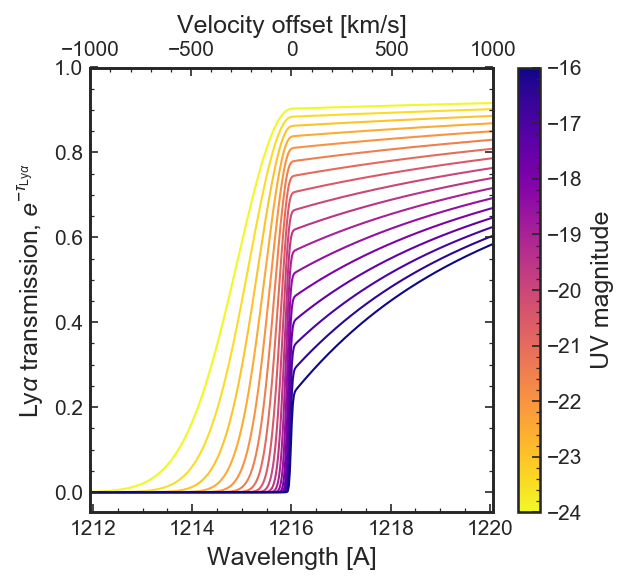

In [460]:
# Plot
s_m = bubbles.scalar_mappable(Muv_tab, cmap='plasma_r')

DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4.3,4))
ax_DV = ax_wave.twiny()
    
for i, Muv in enumerate(Muv_tab):
    ax_wave.plot(wave_em, np.exp(-tau_tot_tab[i]), c=s_m.to_rgba(Muv), lw=1, alpha=1, zorder=0)
    ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[i]), lw=0)

#     ax_wave.plot(wave_em, tau_tot_tab[i], c=s_m.to_rgba(Muv), lw=1, alpha=1, zorder=0)
#     ax_DV.plot(DV_tab, tau_tot_tab[i], lw=0)

plt.colorbar(s_m, label='UV magnitude')

plt.yscale('linear')
# ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

plt.tight_layout()
plt.savefig('../figs/transmission_Muv.pdf')

In [405]:
# Total Lya optical depth for galaxies in ionized bubbles using simple physical model (fesc=1, C=3)
# First column is velocity offset from systemic, other columns are optical depth at quoted UV magnitude

In [461]:
# Save
d = {'DV':DV_tab.value[np.where((DV_tab.value >= -2000) & (DV_tab.value <= 2000))]}
for i, Muv in enumerate(Muv_tab):
    d['%.1f' % Muv] = tau_tot_tab[i][np.where((DV_tab.value >= -2000) & (DV_tab.value <= 2000))]
    
df = pd.DataFrame(data=d)
df.to_csv('../data/tau_total_DV_Muv_C=%.0f_fesc=%.1f.txt' % (C, fesc), sep='\t', index=False)

## What is blue peak transmission as a function of Rion?

In [ ]:
def get_trans_blue(tau_tot_dict, T_min=0.1):
    
    velocity = bubbles.wave_to_DV(bubbles.wave_em).value
    line = bubbles.lineshape_doublepeak(v=velocity, vcenter=-100)
        
    where_blue = np.where((velocity < 0.) & (velocity > -1000.))
    where_red  = np.where((velocity > 0.) & (velocity < 1000.))
    
    line[where_red] = 0.
    line = line/np.trapz(line, velocity)

    trans_blue_dict = {}  # transmission on blue side
    for keys in tau_total_dict.keys():

        trans_tot_tab = np.exp(-tau_total_dict[keys])
        
        transmitted_line = line*trans_tot_tab

        Tigm_blue = np.trapz(transmitted_line, velocity)

        trans_blue_dict[keys] = Tigm_blue
    
    return trans_blue_dict

z_s, z_min, r_slope, T_min = 7., 6., 2., 0.1

tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=r_slope, z_s=z_s, z_min=z_min)

trans_blue_dict = get_trans_blue(tau_total_dict)

trans_blue_im = bubbles.dict_to_image(trans_blue_dict, x=R_ion_tab, y=xHI_01_tab)

#------------------------------------------------------------
# Plot
plt.figure(figsize=(4.5, 4))

trans_minDV_levels = [-500, -400, -300, -200, -100, -50, 0., 50, 100, 200, 300, 400, 500]

# R = R_ion_tab_better#*(1+z_s)
cs = plt.contourf(R_ion_tab, xHI_01_tab, trans_blue_im, 
                 )

plt.colorbar(label=r'Minimum observable $\Delta v$ [km/s]')





## Grid of Nion

In [145]:
z_s   = 7.
z_min = 6.
source_age = 1e7*u.year
wave_em = np.linspace(1200, 1240., 2000) * u.Angstrom

Ndot_ion_tab = np.logspace(-4, 1, 10)*1e57/u.s
  
tau_tot_tab = []
R_ion_tab   = []
for Ndot_ion in Ndot_ion_tab:
    tau_tab, R_ion = bubbles.make_tau(Ndot_ion=Ndot_ion, source_age=source_age, 
                                      wave_em=wave_em, z_s=z_s, z_min=z_min)
    print(Ndot_ion, R_ion)
    tau_HII, tau_IGM, tau_total = tau_tab

    R_ion_tab.append(R_ion.value)
    tau_tot_tab.append(tau_total)
    
tau_tot_tab = np.array(tau_tot_tab)
R_ion_tab   = np.array(R_ion_tab)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1e+53 1 / s 0.13866650680111756 Mpc
3.593813663804626e+53 1 / s 0.2124010994274914 Mpc
1.291549665014884e+54 1 / s 0.3253433585278974 Mpc
4.641588833612783e+54 1 / s 0.4983415868539137 Mpc
1.6681005372000593e+55 1 / s 0.763329973329644 Mpc
5.994842503189409e+55 1 / s 1.1692234073056451 Mpc
2.1544346900318845e+56 1 / s 1.7909468040776753 Mpc
7.742636826811278e+56 1 / s 2.743265688143697 Mpc
2.782559402207126e+57 1 / s 4.201971057215231 Mpc
1.0000000000000001e+58 1 / s 6.436329095641577 Mpc


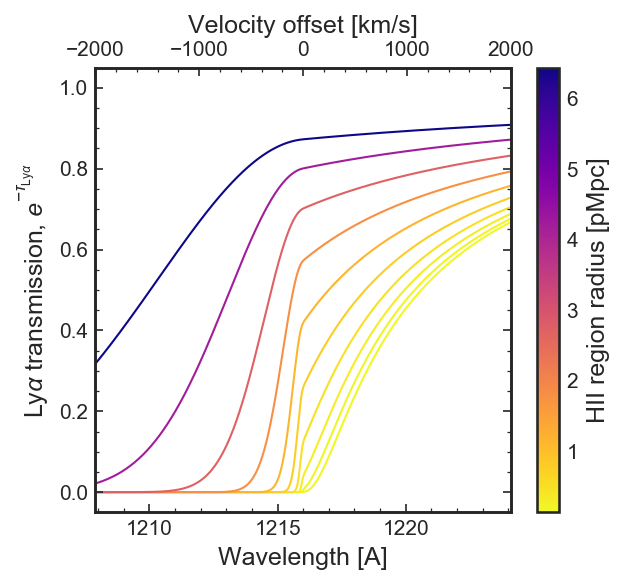

In [146]:
# Plot
s_m = bubbles.scalar_mappable(R_ion_tab, cmap='plasma_r')

DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4.3,4))
ax_DV = ax_wave.twiny()
    
for i, R_ion in enumerate(R_ion_tab):
#     if i % 4 == 0:
        ax_wave.plot(wave_em, np.exp(-tau_tot_tab[i]), c=s_m.to_rgba(R_ion), lw=1, alpha=1, zorder=0)
        ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[i]), lw=0)

plt.colorbar(s_m, label='HII region radius [pMpc]')

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-2000, 2000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

plt.tight_layout()
plt.savefig('../figs/transmission_R_HII.pdf')

## Video of grid

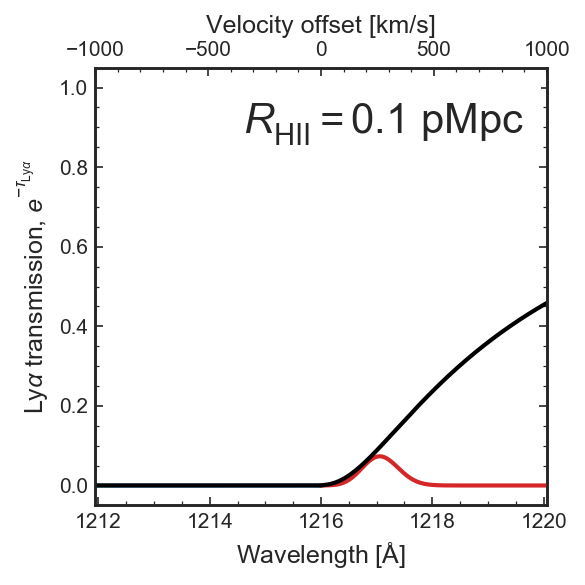

In [149]:
DV_tab = bubbles.wave_to_DV(wave_em)
line_DV  = np.linspace(0., 400, 20)
velocity = bubbles.wave_to_DV(wave_em).value
lines = np.array([bubbles.lineshape_doublepeak(v=velocity, vcenter=DV) for DV in line_DV])


fig, ax_wave = plt.subplots(1,1, figsize=(4,4))
ax_DV = ax_wave.twiny()

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax_DV.set_xlabel('Velocity offset [km/s]')

def update_tau_R(i):
    # Get new tau and R_ion    
    # Plot
    ax_DV.lines[0].set_ydata(np.exp(-tau_tot_tab[i]))
    ax_DV.lines[1].set_ydata((np.exp(-tau_tot_tab[i])*400*lines[10])[velocity < 0.])
    ax_DV.lines[2].set_ydata((np.exp(-tau_tot_tab[i])*400*lines[10])[velocity >= 0.])
            
    # Annotate
    ax_wave.annotate(r'$R_\mathrm{HII}=%.1f$ pMpc' % np.round(R_ion_tab[i], 1), xy=(0.95, 0.85), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w', fontsize=20)
    
# First one
ax_wave.plot(wave_em, np.exp(-tau_tot_tab[0]), lw=0, c='k')
ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[0]), lw=2, c='k')
ax_DV.plot(velocity[velocity < 0.],  (np.exp(-tau_tot_tab[0])*400*lines[10])[velocity < 0.],  c='tab:blue', zorder=0)
ax_DV.plot(velocity[velocity >= 0.], (np.exp(-tau_tot_tab[0])*400*lines[10])[velocity >= 0.], c='tab:red', zorder=0)

# ax_DV.plot(velocity[velocity < 0.],  400*lines[10][velocity < 0.],  c='tab:blue', zorder=0)
# ax_DV.plot(velocity[velocity >= 0.], 400*lines[10][velocity >= 0.], c='tab:red', zorder=0)


# Animate
anim_tau = FuncAnimation(fig, update_tau_R, frames=np.arange(len(R_ion_tab)), 
                         interval=400) # interval in ms

plotname = '../figs/transmission_animate_Rion_linear.gif'

plt.tight_layout()

# plt.savefig(plotname.replace('.gif','_lines.pdf'))
anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Make grid of R_HII, xHI(0.1 Mpc)

Run using scripts/make_tau_grid.py

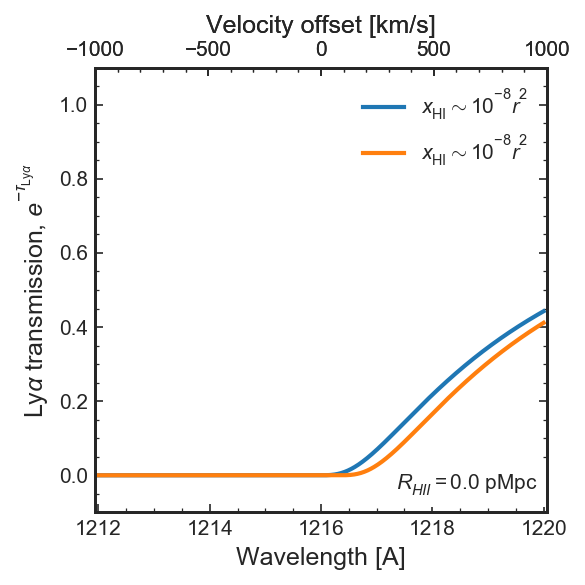

In [27]:
R_ion  = 0.1 * u.Mpc
xHI_01 = 1e-8
trans  = True

fig, ax = plt.subplots(1,1)

tau_tab = bubbles.make_tau_grid(R_ion=R_ion, xHI_01=xHI_01, r_slope=2.)
bubbles.plot_tau(tau_tab[2], bubbles.wave_em, ax=ax, transmission=trans, 
                label=r'$x_\mathrm{HI} \sim 10^{%.0f} r^2$' % np.log10(xHI_01), R_ion=R_ion)

R_ion  = 0.0 * u.Mpc
tau_tab = bubbles.make_tau_grid(R_ion=R_ion, xHI_01=xHI_01, r_slope=2.)
bubbles.plot_tau(tau_tab[2], bubbles.wave_em, ax=ax, transmission=trans, 
                label=r'$x_\mathrm{HI} \sim 10^{%.0f} r^2$' % np.log10(xHI_01), R_ion=R_ion)

# tau_tab = bubbles.make_tau_grid(R_ion=0.8*u.Mpc, xHI_01=xHI_01, r_slope=2.)
# bubbles.plot_tau(tau_tab[0], bubbles.wave_em, ax=ax, transmission=trans, 
#                 label=r'$x_\mathrm{HI} \sim 10^{%.0f} r^2$' % np.log10(xHI_01), R_ion=R_ion)

# tau_tab = bubbles.make_tau_grid(R_ion=1.2*u.Mpc, xHI_01=xHI_01, r_slope=2.)
# bubbles.plot_tau(tau_tab[0], bubbles.wave_em, ax=ax, transmission=trans, 
#                 label=r'$x_\mathrm{HI} \sim 10^{%.0f} r^2$' % np.log10(xHI_01), R_ion=R_ion)


# tau_tab = bubbles.make_tau_grid(R_ion=R_ion, xHI_01=xHI_01, r_slope=0.)
# bubbles.plot_tau(tau_tab[0], bubbles.wave_em, ax=ax, R_ion=R_ion, 
#                  transmission=trans, label='$x_\mathrm{HI} \sim$ const')

## Load dictionary

In [4]:
def load_dict(r_slope=2., z_s=7., z_min=6.):

    fname_dict = '../data/tau_total_dict_RHII_xHI_grid_zs=%.1f_zmin=%.1f_r=%.0f.pickle' % (z_s, z_min, r_slope)
    with open(fname_dict, 'rb') as fp:
        tau_total_dict = pickle.load(fp)

    keys = np.array([[key[0],key[1]] for key in (tau_total_dict.keys())])

    R_ion_tab  = np.unique(keys[:,0])
    xHI_01_tab = np.unique(keys[:,1])
    
    return tau_total_dict, R_ion_tab, xHI_01_tab

In [5]:
# n_HI for xHI = 10^-8
n_HI_test = 1e-8 * 3. * bubbles.n_H(z=7)
print(n_HI_test)

2.8850671708173826e-12 1 / cm3


[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]
[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


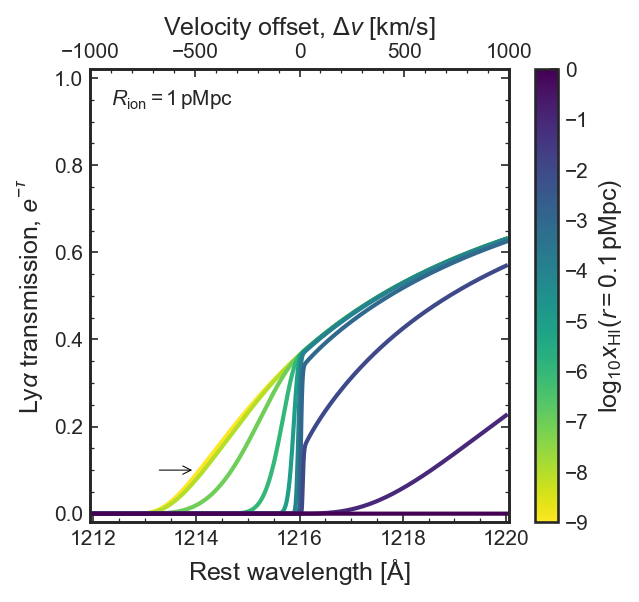

Substituting with a symbol from Computer Modern.


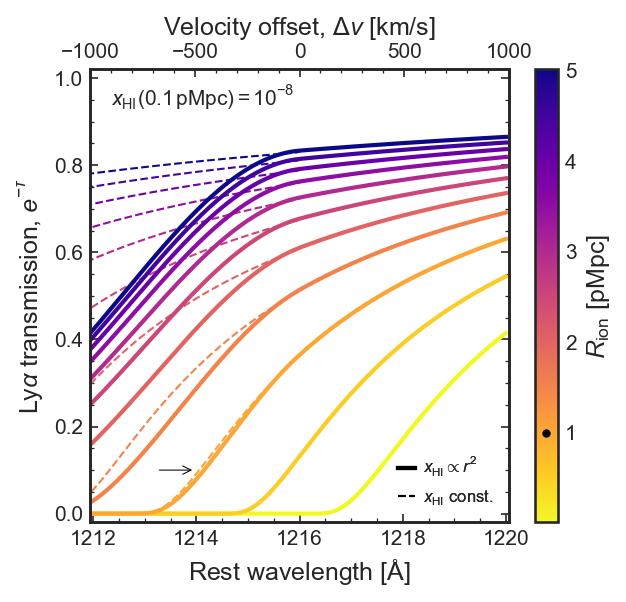

In [7]:
r_slope = 2.
z_s     = 7.
z_min   = 6.
tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=r_slope, z_s=z_s, z_min=z_min)
tau_total_dict_constx, R_ion_tab, xHI_01_tab = load_dict(r_slope=0., z_s=z_s, z_min=z_min)

ylims = (-0.02, 1.02)

# Change xHI
s_m = bubbles.scalar_mappable(xHI_01_tab, cmap='viridis_r')

plt.figure(figsize=(4.5,4))
ax_wave = plt.subplot()

R_ion_key  = 1.01
for xHI_01 in xHI_01_tab[::2]:
    plt.plot(bubbles.wave_em, np.exp(-tau_total_dict[(R_ion_key, xHI_01)]), 
             c=s_m.to_rgba(xHI_01), alpha=1, lw=2)

#     plt.plot(bubbles.wave_em, np.exp(-tau_total_dict_constx[(R_ion_key, xHI_01)]), 
#              c=s_m.to_rgba(xHI_01), alpha=1, lw=1, ls='dashed')

# ax_wave.plot(bubbles.wave_em, np.exp(-tau_total_dict[(1.01, -8.0)]), 
#               zorder=100, c='k', ls='dotted',  alpha=1, lw=5, dashes=(0.05, 3.), dash_capstyle='round')

ax_wave.annotate('', xy=(1214, 0.1), xytext=(1213.2,0.1), xycoords='data',
            arrowprops={'arrowstyle': '->', 'lw':0.5}, va='center')
# DV axes
ax_DV = bubbles.make_DV_axes(ax_wave, bubbles.wave_em, np.exp(-tau_total_dict[(R_ion_key, xHI_01)]))

plt.annotate('$R_\mathrm{ion} = %.0f\,$pMpc' % float(R_ion_key), xy=(0.05,0.92), xycoords='axes fraction')
plt.colorbar(s_m, label='$\log_{10} x_\mathrm{HI} (r=0.1\,$pMpc$)$')

plt.ylim(ylims)
ax_wave.set_xlabel(r'Rest wavelength [$\mathrm{\AA}$]')
ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau}$')

figname_transmission = '../figs/transmission_grid/transmission_xHI_change_zs=%.1f_zmin=%.1f_r=%.0f.pdf' % (z_s, z_min, r_slope)
# plt.savefig(figname_transmission.replace('.pdf', '_fullyionized.pdf'), bbox_inches='tight')
plt.savefig(figname_transmission, bbox_inches='tight')


#============================================
# Change R_HII
s_m = bubbles.scalar_mappable(R_ion_tab, cmap='plasma_r')

plt.figure(figsize=(4.5,4))
ax_wave = plt.subplot()
DV = bubbles.wave_to_DV(bubbles.wave_em)
xHI_01_key  = -8.0

# Grid
for R_ion in R_ion_tab[::5]:   
    plt.plot(bubbles.wave_em, np.exp(-tau_total_dict[(R_ion, xHI_01_key)]), 
             c=s_m.to_rgba(R_ion), alpha=1, lw=2)
    
    plt.plot(bubbles.wave_em, np.exp(-tau_total_dict_constx[(R_ion, xHI_01_key)]), 
             c=s_m.to_rgba(R_ion), alpha=1, lw=1, ls='dashed')

ax_wave.annotate('', xy=(1214, 0.1), xytext=(1213.2,0.1), xycoords='data',
            arrowprops={'arrowstyle': '->', 'lw':0.5}, va='center')

# Fully neutral
R_ion  = 0.0 * u.Mpc
tau_tab = bubbles.make_tau_grid(R_ion=R_ion, xHI_01=10**xHI_01_key, r_slope=2.)
# plt.plot(bubbles.wave_em, np.exp(-tau_tab[2]), 
#              c='k', alpha=1, lw=1, label='$R_\mathrm{ion} = 0\,$pMpc')

# ax_wave.plot(bubbles.wave_em, np.exp(-tau_total_dict[(1.01, xHI_01_key)]), 
#               zorder=100, c='k', ls='dotted',  alpha=1, lw=5, dashes=(0.05, 3.), dash_capstyle='round')
#               c='k', ls='dashed',  alpha=1, lw=0.5, 

#     plt.plot(bubbles.wave_em[DV >= 0.], np.exp(-tau_damp_MR06(DV[DV >= 0.], z=z_s, Rb=R_ion*u.Mpc)),
#              ls='dashed', c=s_m.to_rgba(R_ion), alpha=1, lw=1)
    
r2 = mlines.Line2D([], [], c='k', lw=2, label='$x_\mathrm{HI} \propto r^{\,2}$')
r0 = mlines.Line2D([], [], c='k', ls='dashed', lw=1, label='$x_\mathrm{HI}$ const.')
leg = plt.legend(handles=[r2,r0], loc='lower right', fontsize=8, handlelength=1., handletextpad=0.5,)
ax_wave.add_artist(leg)
    
# DV axes
ax_DV = bubbles.make_DV_axes(ax_wave, bubbles.wave_em, np.exp(-tau_total_dict[(1.01, xHI_01_key)]))

plt.annotate('$x_\mathrm{HI}(0.1\,$pMpc$) = 10^{%.0f}$' % xHI_01_key, xy=(0.05,0.92), xycoords='axes fraction')
cb = plt.colorbar(s_m, label='$R_\mathrm{ion}$ [pMpc]')
cb.ax.plot(np.mean(R_ion_tab), 1, 'k.')

plt.ylim(ylims)

ax_wave.set_xlabel(r'Rest wavelength [$\mathrm{\AA}$]')
ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau}$')

plt.savefig(figname_transmission.replace('xHI_change','RHII_change'), bbox_inches='tight')

## What is R_alpha as a function of xHI?

[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]


(-550, 50)

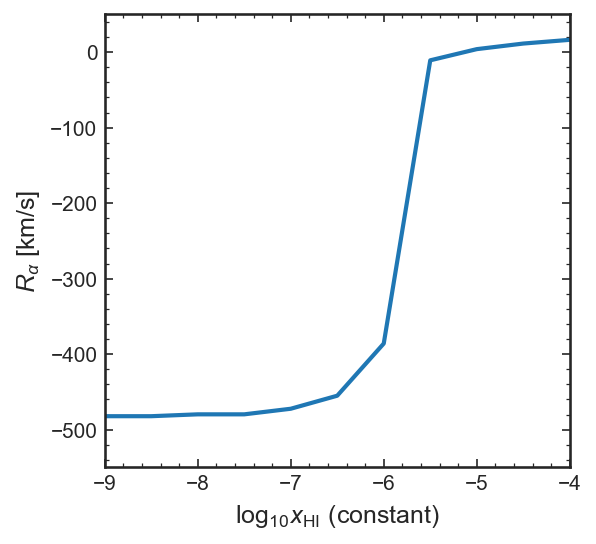

In [8]:
r_slope = 0.
z_s     = 7.
z_min   = 6.
tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=r_slope, z_s=z_s, z_min=z_min)

# Change xHI
plt.figure(figsize=(4.,4))
ax_wave = plt.subplot()

R_ion_key  = 1.01
R_alpha = np.zeros(len(xHI_01_tab))
for i, xHI_01 in enumerate(xHI_01_tab):
    transmission = np.exp(-tau_total_dict[(R_ion_key, xHI_01)])
    R_alpha_wave = bubbles.wave_em[np.where(transmission < 0.1)].max()
    R_alpha[i] = bubbles.wave_to_DV(R_alpha_wave).value

plt.plot(xHI_01_tab, R_alpha)

plt.xlabel(r'$\log_{10} x_\mathrm{HI}$ (constant)')
plt.ylabel(r'$R_\alpha$ [km/s]')

plt.xlim(-9, -4)
plt.ylim(-550,50)

## Grid of transmission

In [336]:
T_min = 0.1
from matplotlib.colors import SymLogNorm
from palettable.cmocean.diverging import Balance_20
from palettable.colorbrewer.diverging import RdBu_10_r

def get_DV_min(tau_dict, T_min=T_min):
    DV = bubbles.wave_to_DV(bubbles.wave_em)

    DV_min_dict = {}
    for keys in tau_dict.keys():
        transmission = np.exp(-tau_dict[keys])
        where = np.where(transmission > T_min)
        if len(where[0]) > 0:
            DV_min_dict[keys] = DV[np.argmax(transmission > T_min)].value
        else:
            DV_min_dict[keys] = np.nan
        
    return DV_min_dict

def plot_DV_map(DV_min_dict, R_ion_tab, xHI_01_tab, R_ion_max=2.5,
                save=False, r_slope=2., z_s=7., z_min=6., T_min=0.1):

    # Make image
    R_ion_tab = R_ion_tab[R_ion_tab < R_ion_max+0.5]
    DV_min = bubbles.dict_to_image(DV_min_dict, x=R_ion_tab, y=xHI_01_tab)
    print(np.nanmin(DV_min), np.nanmax(DV_min))
    DV_min[np.isnan(DV_min)] = 1000.

    # Interpolate
    DV_min_interp = scipy.interpolate.interp2d(R_ion_tab, xHI_01_tab, DV_min, 
                                               kind='linear', fill_value=1000.)

    R_ion_tab_better        = np.arange(np.min(R_ion_tab), np.max(R_ion_tab), 0.05)
    log10_xHI_01_tab_better = np.linspace(np.min(xHI_01_tab), np.max(xHI_01_tab), 20)

    DV_min_interp_better = DV_min_interp(R_ion_tab_better, log10_xHI_01_tab_better)
#     DV_min_interp_better[np.isnan(DV_min_interp_better)] = 400.

    #------------------------------------------------------------
    # Plot
    plt.figure(figsize=(4.5, 4))


    levels = [-1500, -1000, -800, -600, -400, -300, -200, -100, -50, 
                0,
                50, 100, 200, 300, 400, 600, 800, 1000, 1500]

    cf = plt.contourf(R_ion_tab_better, log10_xHI_01_tab_better, DV_min_interp_better, 
                      levels=levels, 
                      cmap=RdBu_10_r.mpl_colormap,
                      norm = SymLogNorm(linthresh=400, linscale=1,base=10)
                      )
    
    plt.colorbar(label=r'Minimum observable $\Delta v_\alpha$ [km/s]',
                 format=ticker.ScalarFormatter()) 
     
    cs = plt.contour(R_ion_tab_better, log10_xHI_01_tab_better, DV_min_interp_better, 
                     levels=levels, linewidths=1, colors='k')

    if r_slope == 2:
        manual_loc = [(1.65,-8.52), (1.5,-8), (1.4,-7.5), (1.3,-7.2), 
                      (1.2,-6.9), (1.1,-6.5), (1.,-6), (0.9,-5),
                      (0.8,-4),
                      (0.4,-4), (0.3,-3), (0.2,-2.5), (0.1,-2),
                      (0.8,-1), (1.,-1), (1.2,-1)] 
    else:
        manual_loc = [(1.65,-8.2), (1.4,-7.9), (1.2,-7.5), (0.9,-7.2), 
                      (0.8,-7), (0.7,-6.6), (0.75,-6), (0.9,-5.5), 
                      (1.,-4),
                      (0.4,-4), (0.3,-3), (0.2,-2.5), (0.1,-2),
                     ] 

    plt.clabel(cs, cs.levels, fmt='%.0f', 
               manual=manual_loc,
               fontsize=9, rightside_up=False, inline_spacing=10.)

    plt.xlabel('Distance to neutral patch, $R_\mathrm{ion}$ [pMpc]')
    
    if r_slope == 0:
        plt.ylabel('$\log_{10} x_\mathrm{HI}$')
        title = '$z_s = %.0f,\; T > %.0f \%%$, constant $x_\mathrm{HI}$' % (z_s, T_min*100)
    else:
        plt.ylabel('$\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')
        title = '$z_s = %.0f,\; T > %.0f \%%$, $x_\mathrm{HI} \propto r^{\,2}$' % (z_s, T_min*100)

    plt.xlim(0., R_ion_max)

    plt.title(title)
    
    if save:
        plt.savefig('../figs/transmission_grid/minimum_observable_DV_transmission_zs=%.1f_zmin=%.1f_r=%.0f_T>%.2f.pdf' % (z_s, z_min, r_slope, T_min), bbox_inches='tight')

### xHI ~ const

-1479.2391019736842 386.46787348860204


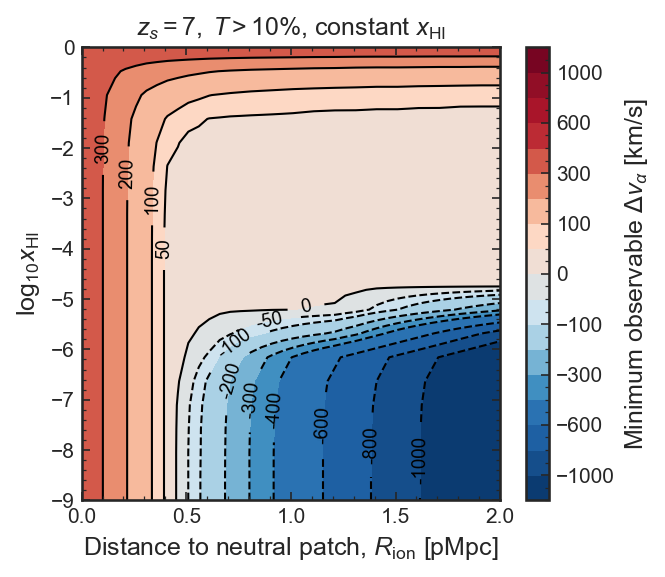

In [338]:
r_slope = 0.
z_s     = 7.
z_min   = 6.
T_min   = 0.1

manual_loc = [(1.65,-8.2), (1.4,-7.9), (1.2,-7.5), (0.9,-7.2), 
                      (0.8,-7), (0.7,-6.6), (0.75,-6), (0.9,-5.5), 
                      (1.,-4),
                      (0.4,-4), (0.3,-3), (0.2,-2.5), (0.1,-2),
             ] 

tau_total_dict_constx, R_ion_tab, xHI_01_tab = load_dict(r_slope=r_slope, z_s=z_s, z_min=z_min)
DV_min_dict_constx = get_DV_min(tau_total_dict_constx, T_min=T_min)

plot_DV_map(DV_min_dict_constx, R_ion_tab, xHI_01_tab, R_ion_max=2., 
            r_slope=r_slope, z_s=z_s, z_min=z_min, T_min=T_min,
            save=True)

### xhi ~ r^2

-1479.2391019736842 954.0771385102393


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


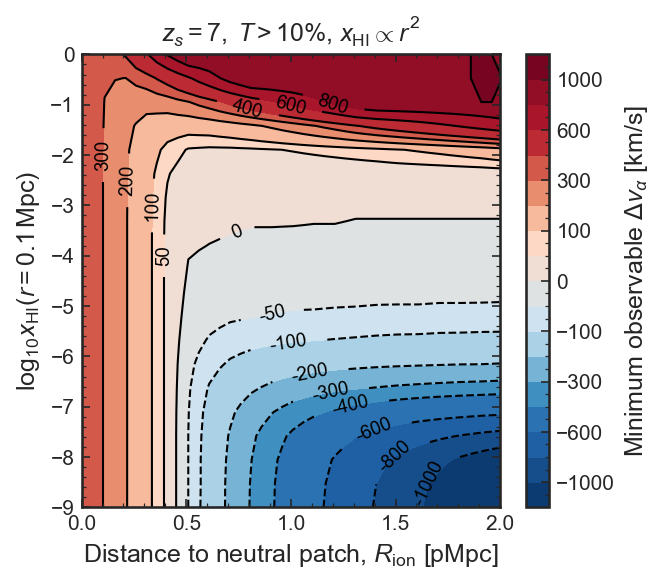

In [314]:
r_slope = 2.
z_s     = 7.
z_min   = 6.
T_min   = 0.1

tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=r_slope, z_s=z_s, z_min=z_min)
DV_min_dict = get_DV_min(tau_total_dict, T_min=T_min)

plot_DV_map(DV_min_dict, R_ion_tab, xHI_01_tab, R_ion_max=2., 
            r_slope=r_slope, z_s=z_s, z_min=z_min, T_min=T_min,
            save=True)

# Add fake lines

-1479.2391019736842 986.1594013157894


Text(0, 0.5, 'Normalized Lya flux')

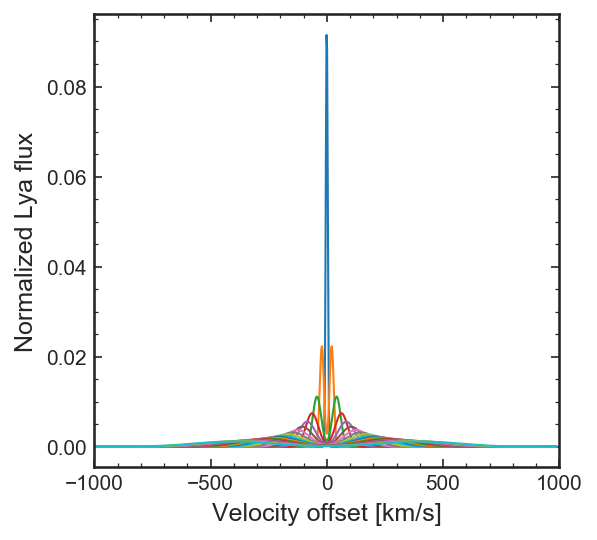

In [249]:
line_DV = np.linspace(-500., 500, 20)
line_DV = np.linspace(0., 400, 20)

velocity = bubbles.wave_to_DV(bubbles.wave_em).value

# lines = np.array([reionizer.line_shape_gauss(v=velocity, vcenter=DV, fwhm=DV, vmin=-2000.) for DV in line_DV])
lines = np.array([bubbles.lineshape_doublepeak(v=velocity, vcenter=DV) for DV in line_DV])

plt.plot(velocity, lines.T, lw=1)
print(velocity.min(), velocity.max())
plt.xlim(-1000, 1000)

plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

# Grid of R_HII, xHI(0.1 Mpc) transmissions

What is minimum DV observable given R_HII and xHI?

In [122]:
def get_transminDV_DVtrans(tau_tot_dict, T_min=0.1):
    
    where_blue = np.where((velocity < 0.) & (velocity > -1000.))
    where_red  = np.where((velocity > 0.) & (velocity < 1000.))

    trans_minDV_dict = {}  # minimum transmitted DV
    trans_DV_dict = {}     # transmission as a function of DV
    for keys in tau_total_dict.keys():

        trans_tot_tab = np.exp(-tau_total_dict[keys])

        trans_DV = [] 
        DV_list  = []
        DV_trans = []
        for i, line in enumerate(lines):

            transmitted_line = line*trans_tot_tab.T

            Tigm_tot_grid  = np.trapz(transmitted_line, velocity)
            Tigm_blue_grid = 2*np.trapz(transmitted_line[where_blue], velocity[where_blue])
            Tigm_red_grid  = 2*np.trapz(transmitted_line[where_red], velocity[where_red])

            trans_DV.append(Tigm_blue_grid)
            trans_DV.append(Tigm_red_grid)
            DV_list.append(-line_DV[i])
            DV_list.append(line_DV[i]) 

            if Tigm_blue_grid > T_min:
                DV_trans.append(-line_DV[i])
            elif Tigm_red_grid > T_min:
                DV_trans.append(line_DV[i])

        DV_list = np.array(DV_list)
        trans_DV = np.array(trans_DV)
        DV_list_sort_i = np.argsort(DV_list)

        DV_list  = DV_list[DV_list_sort_i]
        trans_DV = trans_DV[DV_list_sort_i]

        trans_DV_dict[keys] = np.array([DV_list, trans_DV]).T

        DV_trans = np.array(DV_trans)

        try:
            trans_minDV_dict[keys] = np.min(DV_trans)
        except:
            trans_minDV_dict[keys] = np.nan
            
    return trans_minDV_dict, trans_DV_dict

## What is minimum DV observable given R_HII and xHI?

[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]


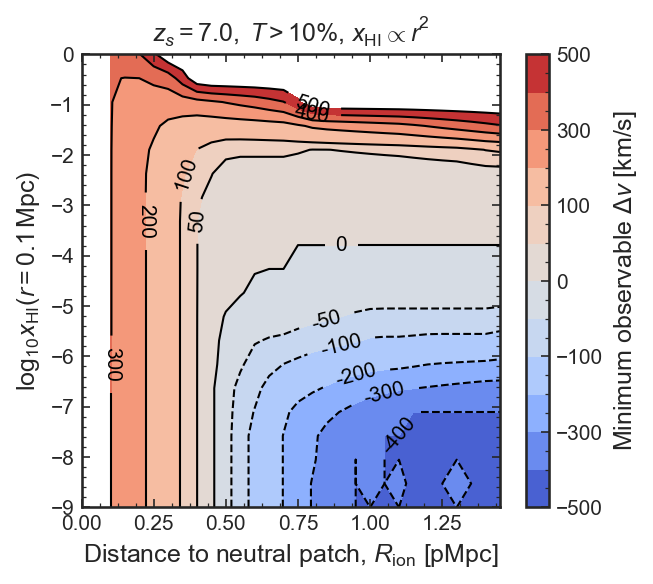

In [262]:
z_s, z_min, r_slope, T_min = 7., 6., 2., 0.1

tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=r_slope, z_s=z_s, z_min=z_min)
trans_minDV_dict, trans_DV_dict = get_transminDV_DVtrans(tau_total_dict, T_min)

trans_minDV_im = bubbles.dict_to_image(trans_minDV_dict, x=R_ion_tab, y=xHI_01_tab)

# Interpolate
trans_minDV_im[np.isnan(trans_minDV_im)] = 600.
trans_minDV_im_interp = scipy.interpolate.interp2d(R_ion_tab, xHI_01_tab, trans_minDV_im, 
                                                   kind='linear', fill_value=500.)

R_ion_tab_better = np.arange(0.1, 1.5, 0.05)
log10_xHI_01_tab_better = np.linspace(-9,0,20)

trans_minDV_im_interp_better = trans_minDV_im_interp(R_ion_tab_better, log10_xHI_01_tab_better)
trans_minDV_im_interp_better[np.isnan(trans_minDV_im_interp_better)] = 300.

#------------------------------------------------------------
# Plot
plt.figure(figsize=(4.5, 4))

trans_minDV_levels = [-500, -400, -300, -200, -100, -50, 0., 50, 100, 200, 300, 400, 500]

R = R_ion_tab_better#*(1+z_s)
cs = plt.contourf(R, log10_xHI_01_tab_better, trans_minDV_im_interp_better, 
                 levels=trans_minDV_levels, cmap='coolwarm')

plt.colorbar(label=r'Minimum observable $\Delta v$ [km/s]')

cs = plt.contour(R, log10_xHI_01_tab_better, trans_minDV_im_interp_better, 
                 levels=trans_minDV_levels, linewidths=1, colors='k')

plt.xlim(0., 1.45)

plt.clabel(cs, cs.levels, fmt='%.0f', inline_spacing=10.)

plt.xlabel('Distance to neutral patch, $R_\mathrm{ion}$ [pMpc]')
if r_slope == 0:
    plt.ylabel('$\log_{10} x_\mathrm{HI}$')
    title = '$z_s = %.1f,\; T > %.0f \%%$, constant $x_\mathrm{HI}$' % (z_s, T_min*100)
else:
    plt.ylabel('$\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')
    title = '$z_s = %.1f,\; T > %.0f \%%$, $x_\mathrm{HI} \propto r^2$' % (z_s, T_min*100)

plt.title(title)
plt.savefig('../figs/transmission_grid/minimum_observable_DV_zs=%.1f_zmin=%.1f_r=%.0f_T>%.2f.pdf' % (z_s, z_min, r_slope, T_min), bbox_inches='tight')

## Can we tell the difference between constant and r^2 bubbles?

[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]
[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]


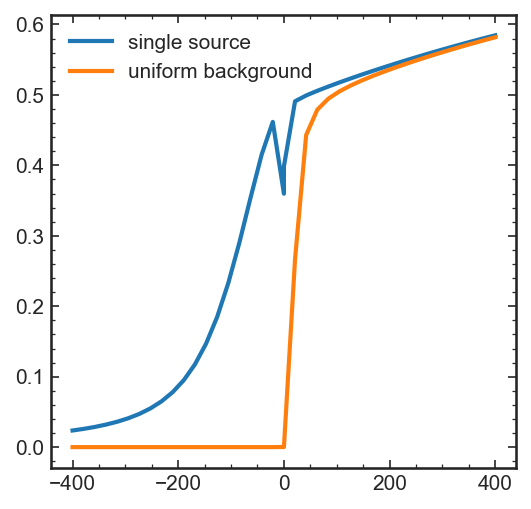

In [120]:
R_test = 1.41

tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=2., z_s=7., z_min=6.)
trans_minDV_dict, trans_DV_dict = get_transminDV_DVtrans(tau_total_dict)

DV = trans_DV_dict[R_test, -6][:,0]
T  = trans_DV_dict[R_test, -6][:,1]

plt.plot(DV, T, label='single source')

tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=0., z_s=7., z_min=6.)
trans_minDV_dict, trans_DV_dict = get_transminDV_DVtrans(tau_total_dict)

DV = trans_DV_dict[R_test, -4][:,0]
T  = trans_DV_dict[R_test, -4][:,1]

plt.plot(DV, T, label='uniform background')

plt.legend()


In [179]:
xHI_max = 1e-5
ionizing_background = 3. * bubbles.n_H(z=z_s) * bubbles.alpha_rec_B(T=1.e4)/xHI_max
print(ionizing_background)
print(ionizing_background/bubbles.Gamma12(6.6)*u.s)

6.6091299772676766e-12 1 / s
28.135930086282148


# Transmission blue, red etc 

## Multiply by transmission

Text(0, 0.5, 'Normalized Lya flux')

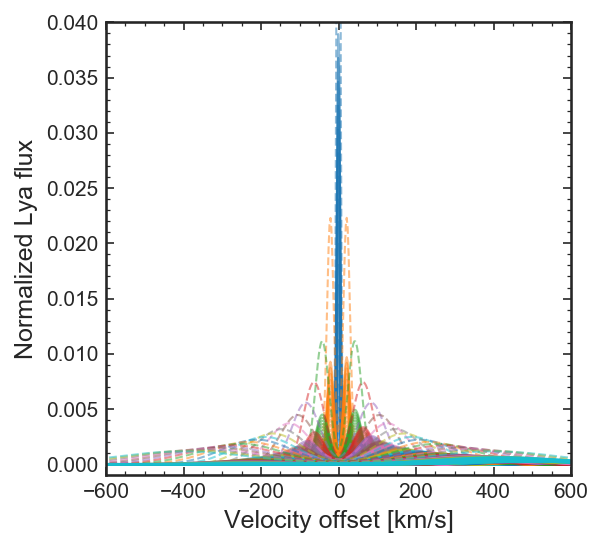

In [236]:
Tigm      = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_blue = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_red = np.zeros((len(lines), len(tau_tot_tab)))

for i, line in enumerate(lines):
    ln = plt.plot(velocity, line, lw=1, alpha=0.5, ls='dashed')
    
    trans_tot_tab = np.exp(-tau_tot_tab)
    plt.plot(velocity, (line*trans_tot_tab).T, c=ln[0].get_color(), lw=1, alpha=0.5)
    
    Tigm_blue[i] = 2*np.trapz(line[velocity < 0.]*trans_tot_tab.T[np.where(velocity < 0.)].T, velocity[velocity < 0.])
    Tigm_red[i]  = 2*np.trapz(line[velocity >= 0.]*trans_tot_tab.T[np.where(velocity >= 0.)].T, velocity[velocity >= 0.])
    Tigm[i]      = np.trapz(line*trans_tot_tab, velocity)
    
plt.xlim(-600, 600)
plt.ylim(-0.001, 0.04)
plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

## Plot both transmissions

In [ ]:
plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(line_DV, R_ion_tab, Tigm_blue.T, cmap='Blues')
plt.colorbar(im, label=r'Fraction of blue peak observed')

# Tigm_levels = [0.001, 0.01, 0.1]
# linestyles=['solid', 'dashed', 'dotted']
Tigm_levels = [0.1]
cs = plt.contour(line_DV, R_ion_tab, Tigm_blue.T, levels=Tigm_levels, 
                 colors='k')

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_bluepeak.pdf', bbox_inches='tight')

## What is minimum R_HII required to see a blue peak?

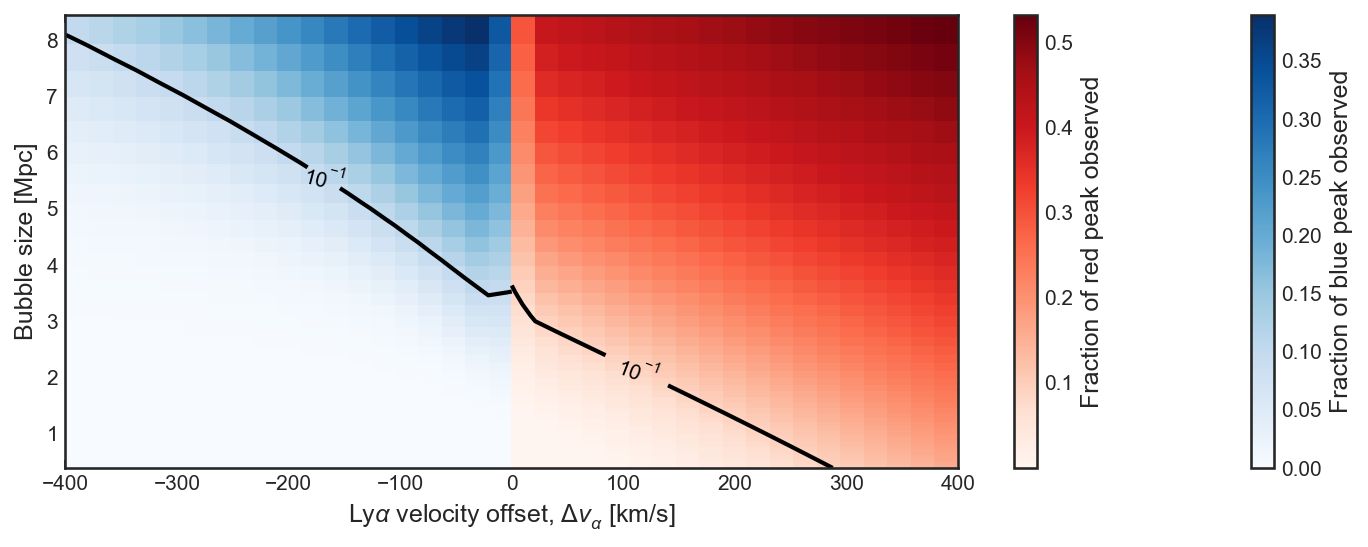

In [242]:
plt.figure(figsize=(12, 4))

im_blue = plt.pcolormesh(-line_DV, R_ion_tab, Tigm_blue.T, cmap='Blues')
plt.colorbar(im_blue, label=r'Fraction of blue peak observed')

# Tigm_levels = [0.001, 0.01, 0.1]
# linestyles=['solid', 'dashed', 'dotted']
Tigm_levels = [0.1]
cs = plt.contour(-line_DV, R_ion_tab, Tigm_blue.T, levels=Tigm_levels, 
                 colors='k')

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)

im_red = plt.pcolormesh(line_DV, R_ion_tab, Tigm_red.T, cmap='Reds')

Tigm_levels = [0.001, 0.01, 0.1]
Tigm_levels = [0.1]

linestyles=['dotted', 'dashed', 'solid']
linestyles=['solid']
cs = plt.contour(line_DV, R_ion_tab, Tigm_red.T, levels=Tigm_levels, 
                 colors='k', linestyles=linestyles)

# ax.Tick.zorder = 1000
plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)
plt.colorbar(im_red, label=r'Fraction of red peak observed')

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('../figs/transmission_bubblesize_deltav.pdf', bbox_inches='tight')

In [250]:
print(np.exp(-5), np.exp(-7))

0.006737946999085467 0.0009118819655545162


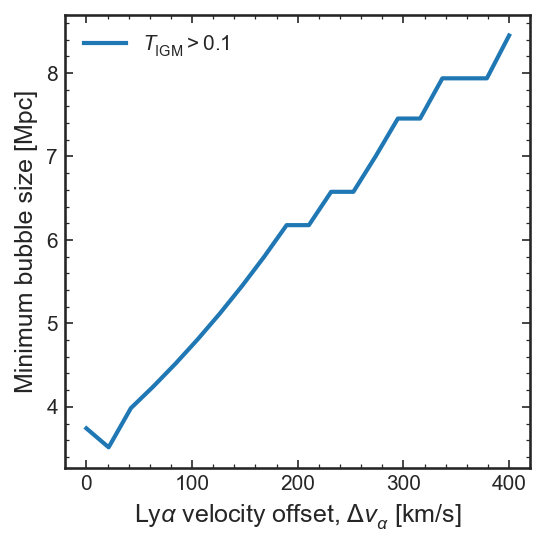

In [49]:
Tcut = 0.1
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion_tab[np.where(Tigm_blue[i] >= Tcut)[0][0]]

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > %.1f$' % Tcut)

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')

## What is minimum R_HII required to see red peak?

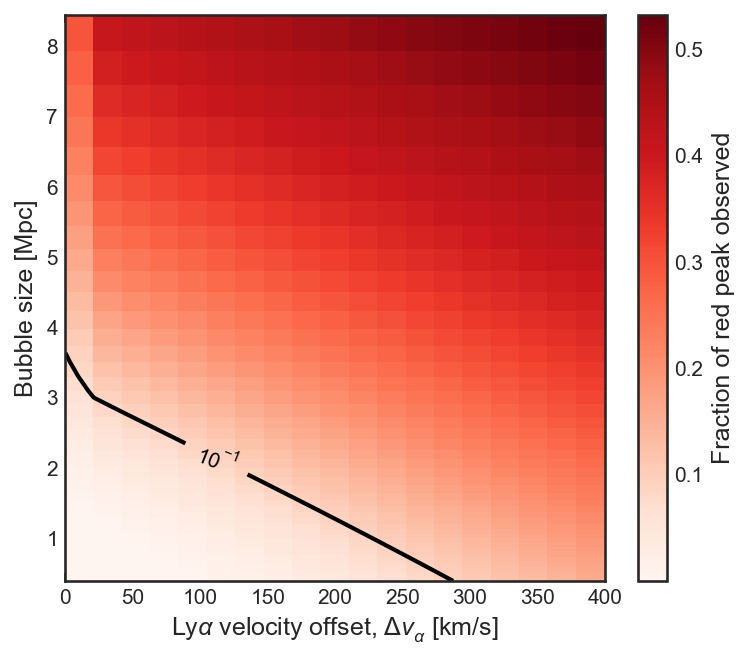

In [63]:
fig, ax = plt.subplots(1,1, figsize=(5.8, 5))

im = plt.pcolormesh(line_DV, R_ion_tab, Tigm_red.T, cmap='Reds')
# ax.set_yscale('log')

Tigm_levels = [0.001, 0.01, 0.1]
Tigm_levels = [0.1]

linestyles=['dotted', 'dashed', 'solid']
linestyles=['solid']
cs = plt.contour(line_DV, R_ion_tab, Tigm_red.T, levels=Tigm_levels, 
                 colors='k', linestyles=linestyles)

# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()

# locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.yaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.minorticks_on()
# ax.Tick.zorder = 1000
plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)
plt.colorbar(im, label=r'Fraction of red peak observed')

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_redpeak.pdf', bbox_inches='tight')

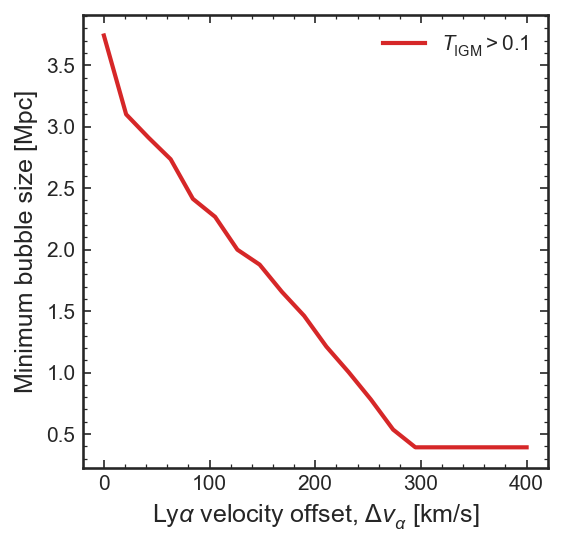

In [64]:
Tcut = 0.1
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion_tab[np.where(Tigm_red[i] >= Tcut)[0][0]]

plt.plot(line_DV, min_bubble_size, c='tab:red', label=r'$T_\mathrm{IGM} > %.1f$' % Tcut)

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav_red.pdf', bbox_inches='tight')

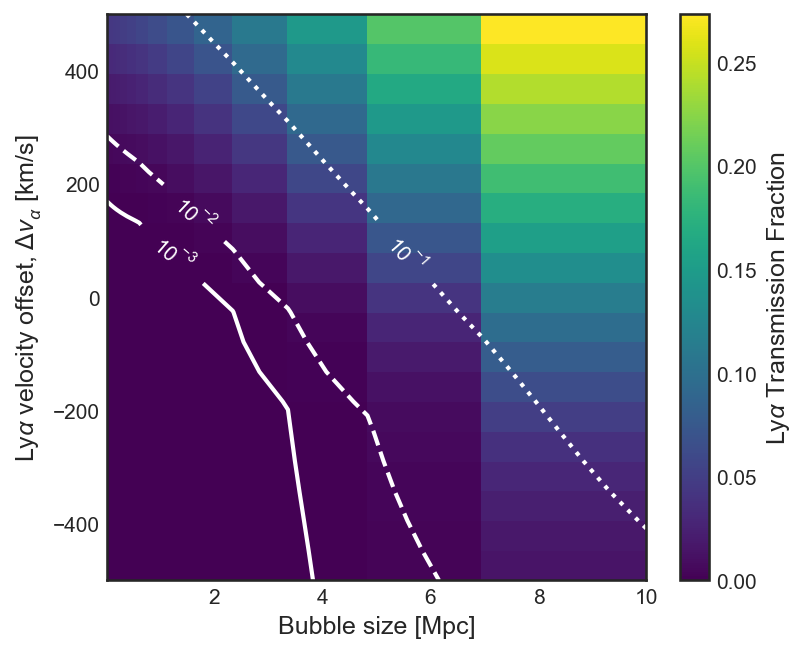

In [319]:
# reionizer.plot_image(Tigm, R_ion.value, line_DV,
#                      xlabel='Bubble size [Mpc]', 
#                      ylabel=r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]', 
#                      cmap='viridis', clabel=r'Ly$\alpha$ Transmission Fraction')

plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(R_ion.value, line_DV, Tigm, cmap='viridis')
plt.colorbar(im, label=r'Ly$\alpha$ Transmission Fraction')

Tigm_levels = [0.001, 0.01, 0.1]
cs = plt.contour(R_ion.value, line_DV, Tigm, levels=Tigm_levels, 
                 colors='w', linestyles=['solid', 'dashed', 'dotted'])

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, fmt=fmt, inline_spacing=20.)

plt.xlabel('Bubble size [Mpc]')
plt.ylabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav.pdf', bbox_inches='tight')

Text(0, 0.5, 'Lya transmission')

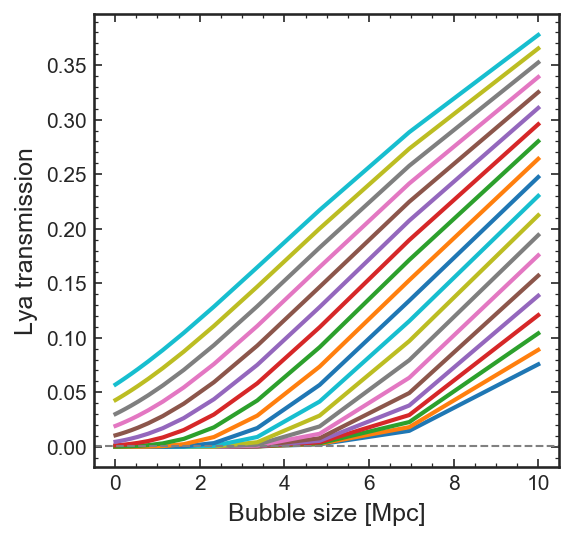

In [320]:
for i, line in enumerate(lines):
    plt.plot(R_ion, Tigm[i])
plt.axhline(1e-3, c='0.5', ls='dashed', lw=1)
plt.xlabel('Bubble size [Mpc]')
plt.ylabel('Lya transmission')

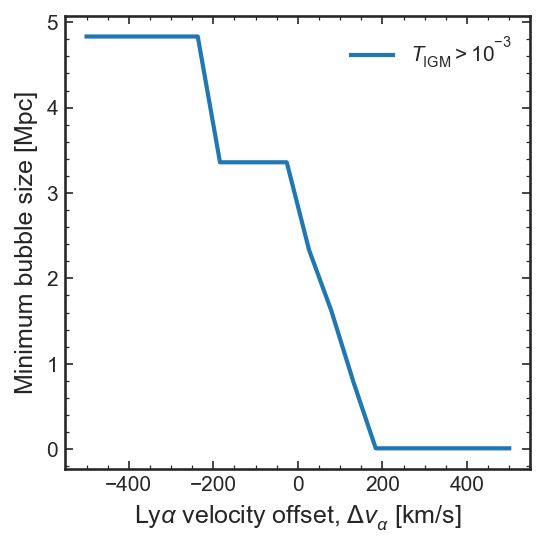

In [321]:
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion[np.where(Tigm[i] >= 1.e-3)[0][0]].value

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > 10^{-3}$')

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')

## Grid of R_HII, xHI(0.1 Mpc) transmissions

### What is minimum R_HII and max xHI where DV is observable?

In [ ]:
trans_dict =  {}
for i, line in enumerate(lines):
    
    trans_dict[line_DV[i]] = {}
    for keys in tau_total_dict.keys():
    
        trans_tot_tab = np.exp(-tau_total_dict[keys])
        
        transmitted_line = line*trans_tot_tab.T
        
        Tigm_tot_grid  = np.trapz(transmitted_line, velocity)
        Tigm_blue_grid = 2*np.trapz(transmitted_line[velocity < 0.], velocity[velocity < 0.])
        Tigm_red_grid  = 2*np.trapz(transmitted_line[velocity >= 0.], velocity[velocity >= 0.])
        
        trans_dict[line_DV[i]][keys] = [Tigm_blue_grid, Tigm_red_grid, Tigm_tot_grid]

In [ ]:
T_min = 0.1
T_min01 = 0.01

R_xHI_trans_blue = {}
R_xHI_trans_red  = {}
for DV in trans_dict.keys():
    
    R_xHI_trans_blue[DV,T_min]  = []
    R_xHI_trans_blue[DV,T_min01]  = []
    R_xHI_trans_red[DV,T_min] = []
    R_xHI_trans_red[DV,T_min01] = []
    
    for keys in trans_dict[DV].keys():
        
        Tigm_blue_grid, Tigm_red_grid, Tigm_tot_grid = trans_dict[DV][keys]
        
        if Tigm_blue_grid > T_min:
            R_xHI_trans_blue[DV,T_min].append([keys[0].value, keys[1]])
        
        if Tigm_red_grid > T_min:
            R_xHI_trans_red[DV,T_min].append([keys[0].value, keys[1]])
        
        if Tigm_blue_grid > T_min01:
            R_xHI_trans_blue[DV,T_min01].append([keys[0].value, keys[1]])
        
        if Tigm_red_grid > T_min01:
            R_xHI_trans_red[DV,T_min01].append([keys[0].value, keys[1]])
            
    R_xHI_trans_blue[DV,T_min] = np.array(R_xHI_trans_blue[DV,T_min])
    R_xHI_trans_red[DV,T_min]  = np.array(R_xHI_trans_red[DV,T_min])
    
    R_xHI_trans_blue[DV,T_min01] = np.array(R_xHI_trans_blue[DV,T_min01])
    R_xHI_trans_red[DV,T_min01]  = np.array(R_xHI_trans_red[DV,T_min01])

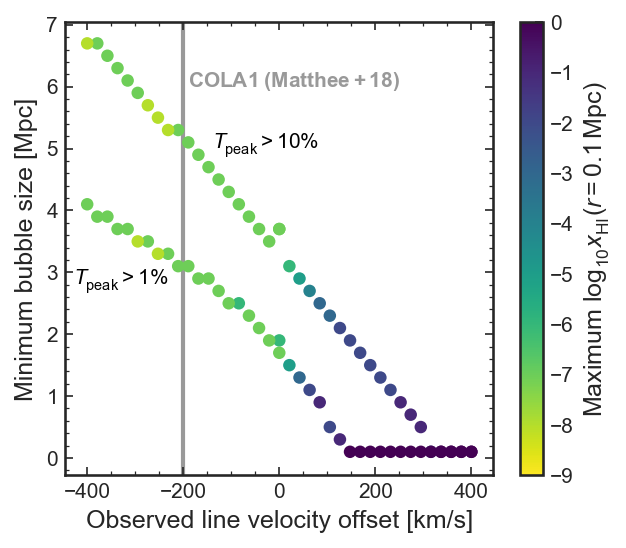

In [164]:
# Change xHI
s_m = bubbles.scalar_mappable(np.log10(xHI_01_tab), cmap='viridis_r')

plt.figure(figsize=(4.6,4))

observed_DV_tab_T_min = []
min_R_HII_tab_T_min   = []
max_xHI_tab_T_min     = []
observed_DV_tab_T_min01 = []
min_R_HII_tab_T_min01   = []
max_xHI_tab_T_min01     = []
for DV in trans_dict.keys():
    # T_min
    min_R_HII_array    = R_xHI_trans_blue[DV,T_min][np.where(R_xHI_trans_blue[DV,T_min][:,0] == np.min(R_xHI_trans_blue[DV,T_min][:,0]))]
    blue_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    min_R_HII_array   = R_xHI_trans_red[DV,T_min][np.where(R_xHI_trans_red[DV,T_min][:,0] == np.min(R_xHI_trans_red[DV,T_min][:,0]))]
    red_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    observed_DV_tab_T_min.append([-DV])
    min_R_HII_tab_T_min.append(blue_max_xHI_array[0])
    max_xHI_tab_T_min.append(blue_max_xHI_array[1])
    
    observed_DV_tab_T_min.append([DV])
    min_R_HII_tab_T_min.append(red_max_xHI_array[0])
    max_xHI_tab_T_min.append(red_max_xHI_array[1])
    
    # T_min_01
    min_R_HII_array    = R_xHI_trans_blue[DV,T_min01][np.where(R_xHI_trans_blue[DV,T_min01][:,0] == np.min(R_xHI_trans_blue[DV,T_min01][:,0]))]
    blue_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    min_R_HII_array   = R_xHI_trans_red[DV,T_min01][np.where(R_xHI_trans_red[DV,T_min01][:,0] == np.min(R_xHI_trans_red[DV,T_min01][:,0]))]
    red_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    observed_DV_tab_T_min01.append([-DV])
    min_R_HII_tab_T_min01.append(blue_max_xHI_array[0])
    max_xHI_tab_T_min01.append(blue_max_xHI_array[1])
    
    observed_DV_tab_T_min01.append([DV])
    min_R_HII_tab_T_min01.append(red_max_xHI_array[0])
    max_xHI_tab_T_min01.append(red_max_xHI_array[1])

observed_DV_tab_T_min = np.array(observed_DV_tab_T_min)
min_R_HII_tab_T_min   = np.array(min_R_HII_tab_T_min)
max_xHI_tab_T_min     = np.array(max_xHI_tab_T_min)

observed_DV_tab_T_min01 = np.array(observed_DV_tab_T_min01)
min_R_HII_tab_T_min01   = np.array(min_R_HII_tab_T_min01)
max_xHI_tab_T_min01     = np.array(max_xHI_tab_T_min01)

plt.annotate('$T_\mathrm{peak} > %.0f \%%$' % (T_min*100), xy=(-140, 5), xycoords='data', color='k')
plt.annotate('$T_\mathrm{peak} > %.0f \%%$' % (T_min01*100), xy=(-430, 2.8), xycoords='data', color='k')

plt.scatter(observed_DV_tab_T_min, min_R_HII_tab_T_min, c=s_m.to_rgba(max_xHI_tab_T_min))
plt.scatter(observed_DV_tab_T_min01, min_R_HII_tab_T_min01, c=s_m.to_rgba(max_xHI_tab_T_min01))

plt.axvline(-200., lw=2, c='0.6', zorder=0)
plt.annotate('$\mathbf{COLA1\;(Matthee+18)}$', xy=(-200+10, 6), xycoords='data', color='0.6')

plt.colorbar(s_m, label='Maximum $\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')
plt.xlabel('Observed line velocity offset [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')
# plt.yscale('log')
plt.savefig('../figs/transmission_bubblesize_deltav_xHI_linear_r=%.0f.pdf' % r_slope, bbox_inches='tight')

# Ionizing background model Khaire & Srianand 2019

[Khaire & Srianand 2019](https://arxiv.org/abs/1801.09693) fiducial quasar SED $\alpha=-1.8$. Which was found to reproduce the measured He II Lyman-α effective optical depths as a function of z and the epoch of He II reionization

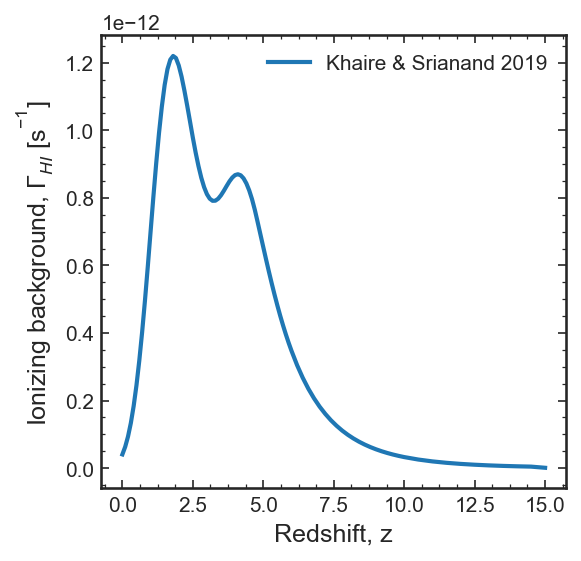

In [173]:
bubbles.plot_Gamma12_bg()

# Miralda-Escude approx for damping wing

In [80]:
R_alpha = 2.02e-8
Lambda  = 6.25e8 / u.s # decay constant for Lya resonance
n0      = 8.5e-5 * ((1. + z_s)/8.)**3. / (u.cm**3.)

z_s = 7.
z_min = 5.

def I(x):
    return x**4.5/(1-x) + 9./7.*x**3.5 + 9./5.*x**2.5 + 3*x**1.5 + 9*x**0.5 - 4.5*np.log((1+x**0.5)/(1-x**0.5))

def delta(DV, z_s):
    return (DV/const.c/(1+z_s)).value

def x1(DV, z_min, z_s):
    return (1+z_min)/(1+z_s)/(1+delta(DV, z_s))

def x2(DV, z_s):
    return 1./(1+delta(DV, z_s))

def tau0(z_s):
    return R_alpha / np.pi * (3*(1216.*u.Angstrom)**3. * Lambda * n0 / (8*np.pi * const.c * Planck15.H(z_s))).to(u.s/u.Mpc)

def tau0_2(z_s):
    Y = 0.24
    return R_alpha / np.pi * 2.1e5 * (Planck15.Om(z_s) * Planck15.h * (1-Y)/0.03) * (Planck15.H0 * (1+z_s)**1.5/Planck15.H(z_s)) * ((1.+z_s)/6.)**1.5

def tau0_Mesinger(z_s):
    tau = 6.43e-9 * bubbles.n_H(z_s) * bubbles.wave_Lya * 0.416 * np.pi * const.e.esu**2. / const.m_e / const.c / Planck15.H(z_s)
    return tau.to(u.cm/u.cm)
    
def tau_ME98(DV, z_min, z_s):
    return tau0_2(z_s) * (1+delta(DV, z_s))**1.5 * (I(x2(DV, z_s)) - I(x1(DV, z_min, z_s)))

def tau0_D14(z_s):
    return 7.5e5 * ((1+z_s)/10)**1.5

def tau_D14(DV, z_min, z_s):
    return tau0_D14(z_s) * R_alpha / np.pi * (1+delta(DV, z_s))**1.5 * (I(x2(DV, z_s)) - I(x1(DV, z_min, z_s)))

def tau_M15(DV, z_min, z_s):
    return tau0_Mesinger(z_s) (I((1+z_s)/8.) - I((1+z_min)/8.))

In [68]:
tau0(z_s), tau0_2(z_s), tau0_Mesinger(z_s)

(<Quantity 2.72442361e+11 s / Mpc>,
 <Quantity 0.06328301>,
 <Quantity 0.00264924>)

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


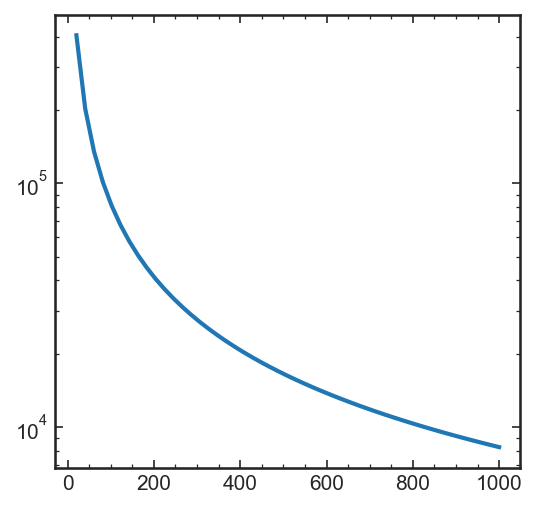

In [84]:
z_s = 7.
z_min = 5.

DV = np.linspace(0., 1000.)

# plt.semilogy(DV, tau_ME98(DV, z_min, z_s))
plt.semilogy(DV, tau_D14(DV, z_min, z_s))

# nH(z)

$$ n_{H, CH00} = 8.5\times10^{-5} \left(\frac{1+z}{8}\right)^3 \; \mathrm{cm}^{-3}$$

$$ n_{H, Madau} = \frac{1-Y}{m_p} \Omega_b(z) \rho_{crit}(z)$$

9.617207721982479e-05 1 / cm3
[0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242]
0.3075


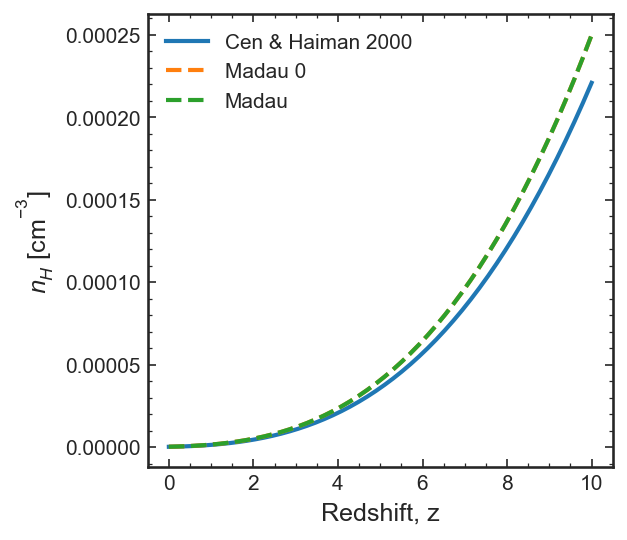

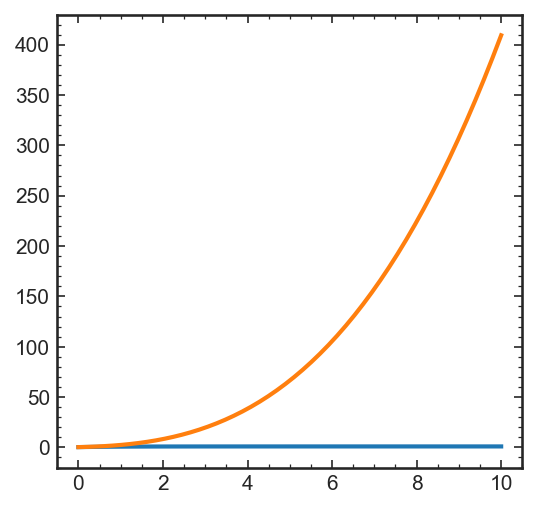

In [140]:
X_p = 0.75

ztab = np.linspace(0., 10)

def n_H(z):
    return (X_p * Planck15.Ob(z) * Planck15.critical_density(z) / const.m_p).to(u.cm**(-3.))

def n_H_0(z):
    return (X_p * Planck15.Ob0 * Planck15.critical_density0 * (1+z)**3. / const.m_p).to(u.cm**(-3.))


def n_H_CenHaiman(z):
    return 8.5e-5 * ((1. + z)/8.)**3. / (u.cm**3.)

plt.plot(ztab, n_H_CenHaiman(ztab), label='Cen & Haiman 2000')
plt.plot(ztab, n_H_0(ztab), ls='dashed', label='Madau 0')
plt.plot(ztab, n_H(ztab), ls='dashed', label='Madau')


plt.xlabel('Redshift, z')
plt.ylabel('$n_H$ [cm$^{-3}$]')
plt.legend()
print(n_H_0(0)*8**3.)
print(n_H_CenHaiman(ztab)/n_H(ztab))

print(Planck15.Om0)

plt.figure()
plt.plot(ztab, Planck15.Om(ztab))
plt.plot(ztab, Planck15.Om0 *(1+ztab)**3.)

# Recombination time

In [88]:
def t_rec(z_s, C=3., T=1e4):
    """
    """        
    t = 1./(C * bubbles.n_H(z_s) * bubbles.alpha_rec_B(T))
    return t
    
def t_ion(r, z_s, Ndot_ion, fesc=1.,
          J_bg=0., qso=True, alpha=-1.8):
    """
    """        
    sigma_ion0 = 6.304e-18*u.cm**2. 
    J_source           = fesc * Ndot_ion * (alpha/(alpha - 3)) * sigma_ion0

    Gamma12_source     = fesc/(4. * np.pi * r**2.) * J_source
    Gamma12_background = J_bg * bubbles.Gamma12(z_s) / u.s

    t = 1./(Gamma12_background + Gamma12_source)
    return t.to(u.yr)

Text(0, 0.5, 'Time [Gyrs]')

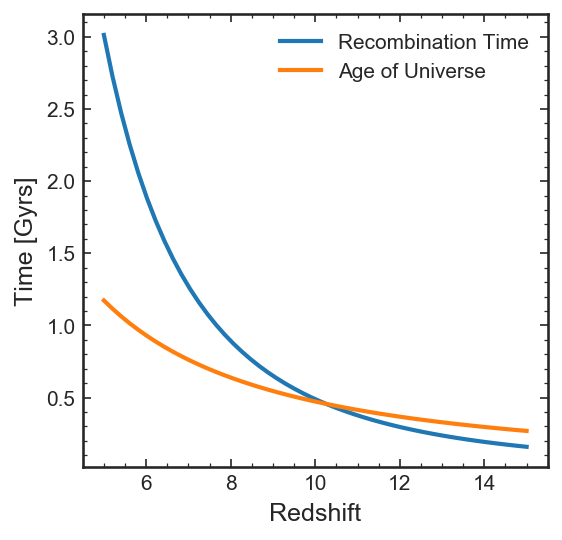

In [90]:
z=10
ztab = np.linspace(5., 15.)
Ndot_ion = bubbles.Muv_to_Nion(Muv=-24, z=z)

Rtab = np.linspace(0., 1)*u.Mpc

# plt.semilogy(Rtab, t_ion(Rtab, z, Ndot_ion))

def t_rec_Bouwens15(z, C, T):
    """
    Recombination time in seconds as a function of redshift
    and clumping factor from Bouwens+2015 
    """
    trec = (0.88 * u.Gyr * ((1.+z)/7)**-3. * (T/2.e4)**-0.7 * (C/3)**-1.)
    return trec

plt.plot(ztab, t_rec(ztab, C=1., T=1e4).to(u.Gyr), label='Recombination Time')
# plt.semilogy(ztab, t_rec_Bouwens15(ztab, C=1., T=1e4).to(u.yr))
plt.plot(ztab, Planck15.age(ztab).to(u.Gyr), label='Age of Universe')

plt.legend()

plt.xlabel('Redshift')
plt.ylabel('Time [Gyrs]')

## Are we in photoionization equilibrium?

Davies+19 $t_\mathrm{eq}^{-1} = \Gamma_\mathrm{bg} + J_s/4\pi r^2$

In [8]:
# recombination rate
bubbles.n_H(z=7)*bubbles.alpha_rec_B(T=1e4)

<Quantity 2.49252077e-17 1 / s>

In [16]:
# photoionization rate
def pi_rate(z_s, r, Ndot_ion, fesc=1, alpha=-2, J_bg=1):
    J_source           = fesc * Ndot_ion * (alpha/(alpha - 3)) * bubbles.sigma_ion0

    Gamma12_source     = J_source / (4. * np.pi * r**2.)
    Gamma12_background = J_bg * bubbles.Gamma12(z_s) / u.s
    return (Gamma12_source + Gamma12_background).to(1/u.s)

In [17]:
pi_rate(z_s=7., r=1.*u.Mpc, Ndot_ion=1e55/u.s)

<Quantity 3.92648864e-13 1 / s>

In [45]:
xHI=1e-4

dxdt = (1-xHI)**2. * bubbles.n_H(z=7)*bubbles.alpha_rec_B(T=1e4) - xHI * pi_rate(z_s=7., r=0.5*u.Mpc, Ndot_ion=1e56/u.s)
dxdt.to(1./u.Myr)

<Quantity -0.02639052 1 / Myr>

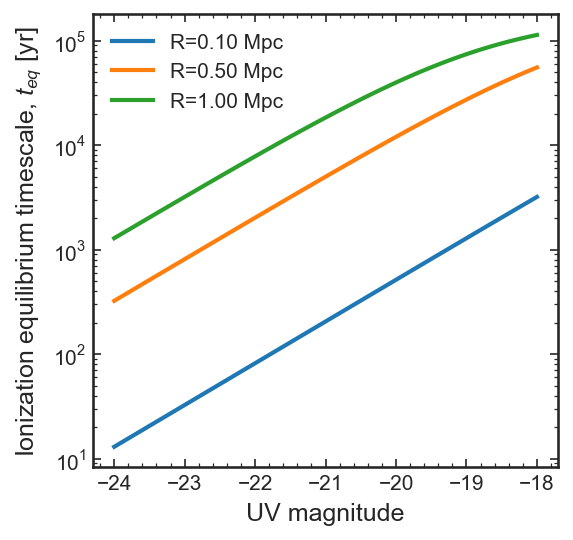

In [81]:
Muv_tab = np.linspace(-24,-18)
Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=7., alpha_s=-1.8, beta=-2)

for r in [0.1, 0.5, 1]:
    
    t_eq = 1./pi_rate(z_s=7., r=r*u.Mpc, Ndot_ion=Ndot_ion_tab)

    plt.semilogy(Muv_tab, t_eq.to(u.yr), label='R=%.2f Mpc' % r)

plt.xlabel('UV magnitude')
plt.ylabel('Ionization equilibrium timescale, $t_{eq}$ [yr]')

plt.legend()

# IGM temperature

Text(0, 0.5, 'Temperature [K]')

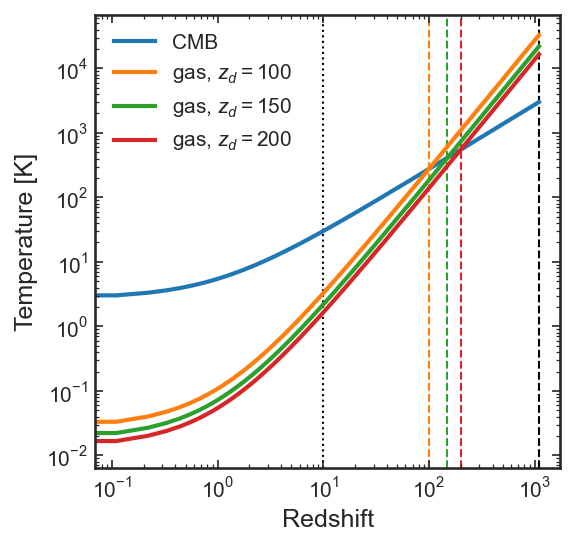

In [39]:
ztab = np.linspace(0, 1100, 10000)

def T_CMB(z):
    T_CMB_0 = 2.73
    return T_CMB_0 * (1 + z)

def T_gas(z, z_decouple):
    T_gas_0 = T_CMB(z_decouple) / (1+z_decouple)**2.
    return T_gas_0 * (1 + z)**2.

plt.loglog(ztab, T_CMB(ztab), label='CMB')

for z_decouple in [100, 150, 200]:
    ln = plt.plot(ztab, T_gas(ztab, z_decouple), label=f'gas, $z_d = {z_decouple}$')
    plt.axvline(z_decouple, zorder=0, lw=1, ls='dashed', c=ln[0].get_color())

plt.axvline(1100, zorder=0, lw=1, ls='dashed', c='k')
plt.axvline(10, zorder=0, lw=1, ls='dotted', c='k')

plt.legend()

plt.xlabel('Redshift')
plt.ylabel('Temperature [K]')